Okay first thing's first, let's get the prerequisites installed. Aerosandbox will provide the simulation environment, and baseline will include gym and the related requirements for training a model to optimize within that simulation.

🚨 Using Python 3.9.6 (3.11.x has compatability issues with AeroSandbox)

In [1]:
# # Install a pip package in the current Jupyter kernel 🚨RUN THIS CELL ONCE FOR YOUR ENVIRONMENT
# import sys
# !"{sys.executable}" -m pip install "aerosandbox[full]"
# !"{sys.executable}" -m pip install "gymnasium[all]"
# !"{sys.executable}" -m pip install "stable_baselines3[extra]"
# !"{sys.executable}" -m pip install "tensorboard"

Alright let's set up the custom environment

First let's instantiate a plane with basic geometry:

In [2]:
#Helper
import aerosandbox.numpy as np
def flatten_list(nested_item):
    flattened = []
    
    if isinstance(nested_item, (list, np.ndarray)):
        for item in nested_item:
            flattened.extend(flatten_list(item))
    else:
        flattened.append(nested_item)
    
    return flattened

def offsetsToLocations(offsets, minXGap):
    # Initialize an empty list to store the resulting locations
    locations = []
    # Initialize the starting location
    previous_location = [0, 0, 0]
    current_location = [0, 0, 0]
    
    # Iterate through each offset in the list
    for offset in offsets:
        locations.append(current_location.copy())
        previous_location = current_location.copy()
        current_location = [
            current_location[0] + offset[0],
            current_location[1] + offset[1],
            current_location[2] + offset[2],
        ]
        if(current_location[1] - previous_location[1] < minXGap):
            current_location[1] = previous_location[1] + minXGap
        
    
    return locations

def locationsToOffsets(locations):
    # Initialize an empty list to store the resulting offsets
    offsets = []
    
    # Initialize the previous location
    prev_location = [0, 0, 0]
    
    # Iterate through each location in the list
    for location in locations:
        # Calculate the offset as the difference between the current and previous locations
        offset = [location[i] - prev_location[i] for i in range(3)]
        
        # Append the offset to the list of offsets
        offsets.append(offset)
        
        # Update the previous location for the next iteration
        prev_location = location
    
    return offsets

In [8]:
import aerosandbox as asb
import gymnasium as gym
from gymnasium import spaces
import numpy as np
	
class AeroEnv(gym.Env):

	# construct and save self.airplane from self.xsecs
	def constructAirplane(self):
		self.airplane = asb.Airplane(
			name="TestPlane",
			xyz_ref=[0, 0, 0],        # Reference for moments
			wings=[asb.Wing(
					name="Wing",    
					symmetric=True,
					xsecs=self.xsecs
				)],
		)
	
	#attempting to constraint reward
	def getReward(self):
		lift = self.aero["L"]
		drag = self.aero["D"]
		reward = lift/drag
		
		if(drag < 0 or lift < 0 or lift > 300 or drag > 300):
			reward = 0

		# if(reward > 120): #likely a ridiculous value
		# 	reward = -(reward - 120)
		
		#final constraints, to prevent insanely negative rewards
		reward = max(reward, 0)
		reward = min(reward, 150)
		# reward = reward*(self.currStep+1)/self.episodeSteps
			

		return reward

	# construct and safe self.vlm()
	def runAero(self):
		self.vlm = asb.VortexLatticeMethod(
			airplane=self.airplane,
			op_point=asb.OperatingPoint(
				velocity=22.22,  # 80kph
				alpha=0,  # degree
			),
			
		)
		self.vlm.run_symmetric = True
		self.aero = self.vlm.run()
		
	# get observations from current self.xsecs
	def get_observation_vector(self):
		obs = []
		for xsec in self.xsecs:
			# xyz_le is a list of three values
			obs.extend(xsec.xyz_le)
			
			# chord and twist are single values
			obs.append(xsec.chord)
			obs.append(xsec.twist)

			# KulfanAirfoil attributes
			# Both upper_weights and lower_weights are numpy arrays
			obs.extend(xsec.airfoil.upper_weights.tolist())
			obs.extend(xsec.airfoil.lower_weights.tolist())

			# leading_edge_weight, N1, and N2 are single values
			obs.append(xsec.airfoil.leading_edge_weight)
			obs.append(xsec.airfoil.N1)
			obs.append(xsec.airfoil.N2)
		# Append aerodynamics output at the end
		# - 'F_g' : an [x, y, z] list of forces in geometry axes [N]
		# - 'F_b' : an [x, y, z] list of forces in body axes [N]
		# - 'F_w' : an [x, y, z] list of forces in wind axes [N]
		# - 'M_g' : an [x, y, z] list of moments about geometry axes [Nm]
		# - 'M_b' : an [x, y, z] list of moments about body axes [Nm]
		# - 'M_w' : an [x, y, z] list of moments about wind axes [Nm]
		# - 'L' : the lift force [N]. Definitionally, this is in wind axes.
		# - 'Y' : the side force [N]. This is in wind axes.
		# - 'D' : the drag force [N]. Definitionally, this is in wind axes.
		# - 'l_b', the rolling moment, in body axes [Nm]. Positive is roll-right.
		# - 'm_b', the pitching moment, in body axes [Nm]. Positive is pitch-up.
		# - 'n_b', the yawing moment, in body axes [Nm]. Positive is nose-right.
		# - 'CL', the lift coefficient [-]. Definitionally, this is in wind axes.
		# - 'CY', the sideforce coefficient [-]. This is in wind axes.
		# - 'CD', the drag coefficient [-]. Definitionally, this is in wind axes.
		# - 'Cl', the rolling coefficient [-], in body axes
		# - 'Cm', the pitching coefficient [-], in body axes
		# - 'Cn', the yawing coefficient [-], in body axes
		drag = self.aero["D"]
		lift = self.aero["L"]
		drag = np.tanh((drag-50)/50)
		lift = np.tanh((lift-50)/50)
		obs.append(lift)
		obs.append(drag)
		obs.append(self.currStep)
		return np.array(obs, dtype=np.float32)
	
	def __init__(self, 
			  # === Key Parameters ===
			  episodeSteps,
			  kulfanWeightResolution, 	#How many kulfan weights per XSec? More = more intricate designs. Something like 5-8 should be enough...
			  numChords, 				#How many independently controlled foils along length of wing 
			  minChordSpacing,
			  minChordLength,

			  # === Initial Values ===
			  initialYSpacing, 			#Initial spacing of the cross sections
			  initialChordLength, 		#Initial length from front to back of each cross section in wing
			  initialUpperKulfan, 		#Upper kulfan weight initial values (controls curvature of top of wing)
			  initialLowerKulfan, 		#Lower Kulfan weight initial values (controls curvature of bottom of wing)
			  initialLEW, 				#Leading edge weight initial values
			  initialN1, 				#Initial N1 value (forward shift of wing curve shape)
			  initialN2, 				#Initial N2 value (backwards shift of wing curve shape)
			  
			  # === Changing Values ===
			  dX_bounds, 				#How much to allow shift of each cross section per time step in forward/backwards direction
			  dY_bounds, 				#How much to allow shift of each cross section per time step in left/right direction (stubbier wings)
			  dZ_bounds, 				#How much to allow shift of each cross section per time step in up/down direction (wingtips?)
			  dChord_bounds, 			#How much to allow each cross section to change in length per timestep (wider wings? front-back length)
			  dTwist_bounds, 			#How much (in DEGREES) to allow rotation of each cross section per timestep about leading edge
			  KT_bounds, 				#Min/max upper kulfan weights (should be 0,>0)
			  KB_bounds, 				#Max lower kulfan weights (should be <0,0 unless you want to create gaps on bottom of wing that arc up)
			  N_bounds, 				#Bounds of either N value (1, ?)
			  LEW_bounds, 				#Bounds of leading edge weight (??? TODO: Learn what the fuck this does lmao. Experiment)
		):
		super(AeroEnv, self).__init__() #Initialize gym enviro
		self.numChords = numChords
		self.kulfanWeightResolution = kulfanWeightResolution
		self.minChordSpacing = minChordSpacing
		self.minChordLength = minChordLength
		self.episodeSteps = episodeSteps
		
		# Lower and upper bounds for each of the parameters
		low = np.array([dX_bounds[0], dY_bounds[0], dZ_bounds[0], dChord_bounds[0], dTwist_bounds[0]] + [KT_bounds[0]]*kulfanWeightResolution + [KB_bounds[0]]*kulfanWeightResolution + [N_bounds[0], N_bounds[0], LEW_bounds[0]], dtype=np.float32)
		high = np.array([dX_bounds[1], dY_bounds[1], dZ_bounds[1], dChord_bounds[1], dTwist_bounds[1]] + [KT_bounds[1]]*kulfanWeightResolution + [KB_bounds[1]]*kulfanWeightResolution + [N_bounds[1], N_bounds[1], LEW_bounds[1]], dtype=np.float32)
		self.vectorLengthPerXSec = len(low)
		# Creates a much bigger vector, action bounds PER cross section.
		oLow = low.copy()
		oHigh = high.copy()
		low = np.tile(low, numChords) 
		high = np.tile(high, numChords)

		# === Establish bounds for leading edges === 
		oLow[0]=oLow[0]*episodeSteps + 0 # 0 here is the initial value min
		oLow[1]=0 # 0 here is the initial value min
		oLow[2]=oLow[2]*episodeSteps + 0 # 0 here is the initial value min

		oHigh[0]=oHigh[0]*episodeSteps + 0 # 0 here is the initial value max
		oHigh[1]=oHigh[1]*episodeSteps*numChords # initial value max is gonna be the farthest chord out
		oHigh[2]=oHigh[2]*episodeSteps + 0 # 0 here is the initial value max

		# === Establish bounds for CHORD and TWIST === 
		oLow[3]=oLow[3]*episodeSteps + initialChordLength 
		oLow[4]=oLow[4]*episodeSteps + 0 

		oHigh[3]=oHigh[3]*episodeSteps + initialChordLength
		oHigh[4]=oHigh[4]*episodeSteps + 0

		# === Establish KT / KB weight bounds, N bounds, LEW bounds ===
		# No need because absolute value, so bounds are same as action bounds

		oLow = np.tile(oLow, numChords) 
		oHigh = np.tile(oHigh, numChords)

		# === Establish Aerodynamic Bounds (AFTER tiling because not 1 per chord) ===
		oLow = np.append(oLow, [-1, -1]) #Lift, Drag: I intend to use tanH
		oHigh = np.append(oHigh, [1, 1]) #Lift, Drag: I intend to use tanH		

		# === Establish Episode Bounds (AFTER tiling because not 1 per chord) ===
		oLow = np.append(oLow, 0) 
		oHigh = np.append(oHigh, episodeSteps) 	

		self.observation_space = spaces.Box(low=oLow, high=oHigh, dtype=np.float32) #there are 18 additional values provided by vlm.run(), but Im just using 2, Lift and Drag
		self.action_space = spaces.Box(low=low, high=high, dtype=np.float32)
		

		# Initial values for cross sections
		self.init_xyz_le_offsets = [[0, initialYSpacing, 0]]*self.numChords
		self.init_chord = [initialChordLength] * self.numChords  														
		self.init_twist = [0] * self.numChords  														
		self.init_upper_weights = [np.array([initialUpperKulfan] * self.kulfanWeightResolution,np.float32) for _ in range(self.numChords)]
		self.init_lower_weights = [np.array([initialLowerKulfan] * self.kulfanWeightResolution,np.float32) for _ in range(self.numChords)]
		self.init_leading_edge_weight = [initialLEW] * self.numChords  										
		self.init_N1 = [initialN1] * self.numChords 															
		self.init_N2 = [initialN2] * self.numChords


		self.init_xyz_le = offsetsToLocations(self.init_xyz_le_offsets, minXGap=self.minChordSpacing)
		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i],
			)
		) for i in range(self.numChords)]
		self.constructAirplane()
		self.currStep = 0
		
	def step(self, action):
		self.currStep += 1
		#Turn chord positions into offsets
		currPos=[]
		for i in range(self.numChords):
			# Apply dX, dY, dZ
			currPos.append([
				self.xsecs[i].xyz_le[0],
				self.xsecs[i].xyz_le[1],
				self.xsecs[i].xyz_le[2]
			])
		
		offsets = locationsToOffsets(currPos)
		for i in range(self.numChords):
			idx = i * self.vectorLengthPerXSec
			# Apply dX, dY, dZ
			offsets[i] = [
				offsets[i][0] + action[idx], 		#x + dx
				offsets[i][1] + action[idx + 1],	#y + dy
				offsets[i][2] + action[idx + 2]		#z + dz
			]
		
		newXYZ_le_positions = offsetsToLocations(offsets, minXGap=self.minChordSpacing)

		for i in range(self.numChords):
			idx = i * self.vectorLengthPerXSec
			newXYZ_le = newXYZ_le_positions[i]
			# Apply dChord, dTwist
			newChord = self.xsecs[i].chord + action[idx + 3] #chord + dchord
			newTwist = self.xsecs[i].twist + action[idx + 4]

			# Set KB, KT 
			newUpper_weights = np.array([action[idx + 5 + j] for j in range(self.kulfanWeightResolution)], np.float32)
			newLower_weights = np.array([action[idx + 5+self.kulfanWeightResolution + j] for j in range(self.kulfanWeightResolution)], np.float32)
			
			# Set LEW, N1, N2
			newLeading_edge_weight = action[idx + 5+2*self.kulfanWeightResolution] 	# LEW = action's LEW
			newN1 = action[idx + 6+2*self.kulfanWeightResolution] 					# N1 = action's N1
			newN2 = action[idx + 7+2*self.kulfanWeightResolution]					# N2 = action's N2

			self.xsecs[i] = asb.WingXSec(
				xyz_le=([0,0,0] if i == 0 else newXYZ_le), #might not be needed
				chord=max(newChord, self.minChordLength),
				twist=newTwist,
				airfoil=asb.KulfanAirfoil(
					leading_edge_weight=newLeading_edge_weight,
					lower_weights=newLower_weights,
					upper_weights=newUpper_weights,
					N1=newN1,
					N2=newN2
				)
			)

		self.constructAirplane()
		self.runAero()
		
		obs = self.get_observation_vector()				# observation (ObsType): An element of the environment's observation_space as the next observation due to the agent actions.
		reward = self.getReward()						# reward (SupportsFloat): The reward as a result of taking the action.
		terminated = bool(reward >= 120) 				# terminated (bool): Whether the agent reaches the terminal state (as defined under the MDP of the task)
		truncated = bool(reward >= 120)	 				# truncated (bool): Whether the truncation condition outside the scope of the MDP is satisfied.
		info = {"lift": self.aero["L"], "drag": self.aero["L"]}	# info (dict): Contains auxiliary diagnostic information (helpful for debugging, learning, and logging).
		
		return obs, reward, terminated, truncated, info 
    
	def reset(self, seed=123):
		super().reset(seed=seed)
		self.currStep = 0
		# Reinitialize wing sections to their initial states
		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i]
			)
		) for i in range(self.numChords)]

		randomAction = self.action_space.sample()
		self.step(randomAction)

		self.constructAirplane()
		self.runAero()
		
		liftCoeff = self.aero["CL"]
		dragCoeff = self.aero["CD"]

		obs = self.get_observation_vector()
		info = {"lift": liftCoeff, "drag": dragCoeff} 
		return obs, info
	
	def render(self):
		self.runAero()
		print(self.getReward())
		self.airplane.draw_three_view()
		# self.vlm.draw()
	
	def close (self):
		...

In [4]:
# ##SanityCheck
# env = AeroEnv(
#     episodeSteps=40,
#     numChords=5, 
#     minChordLength=0.1,
#     minChordSpacing=0.4,
# 	initialYSpacing=0.15, 
# 	initialChordLength=0.1, 
# 	initialUpperKulfan=1, 
# 	initialLowerKulfan=-0.2, 
# 	initialLEW=0, 
# 	initialN1=3, 
# 	initialN2=1, 
#     dX_bounds = (-0.05, 0.05),
# 	dY_bounds = (-0.2, 0.2),
# 	dZ_bounds = (0, 0),
# 	dChord_bounds = (-0.1, 0.1),
# 	dTwist_bounds = (0, 0),
# 	KT_bounds = (0, 1),
# 	KB_bounds = (-1, 0),
# 	N_bounds = (1, 4),
# 	LEW_bounds = (0, 0.3),
# 	kulfanWeightResolution = 7)

# obs = env.reset()
# random_action = env.action_space.sample()
# env.step(random_action)
# env.render()



In [5]:
steps = 5 #steps per episode used in model training before resetting

def make_env():
    def _init():
        env = AeroEnv(
            episodeSteps=steps,
            numChords=4, 
            minChordLength=0.2,
            minChordSpacing=0.1,
            initialYSpacing=1, 
            initialChordLength=1, 
            initialUpperKulfan=1, 
            initialLowerKulfan=-0.3, 
            initialLEW=0.1, 
            initialN1=1, 
            initialN2=1, 
            dX_bounds = (-1, 0),
            dY_bounds = (-1, 1),
            dZ_bounds = (0, 0),
            dChord_bounds = (-0.5, 0.5),
            dTwist_bounds = (0, 0),
            KT_bounds = (0, 0.6),
            KB_bounds = (-0.2, 0),
            N_bounds = (1, 3),
            LEW_bounds = (0, 0.1),
            kulfanWeightResolution = 3
        )
        return env
    return _init

In [6]:
from stable_baselines3 import PPO
import os
import time
# from stable_baselines3.common.callbacks import EvalCallback
# from stable_baselines3.common.vec_env import DummyVecEnv
# from stable_baselines3.common.vec_env import VecNormalize
import copy

models_dir = f"models/A2C-{int(time.time())}"
logdir = f"logs/A2C-{int(time.time())}"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

# envs = [make_env() for _ in range(3)]
# env = DummyVecEnv(envs)
# env = VecNormalize(env)
env = make_env()()
# evalEnv = copy.deepcopy(env)
# eval_callback = EvalCallback(
#     eval_env=evalEnv, 
#     best_model_save_path='./logs/best_model/',
#     log_path='./logs/eval_log/', 
#     eval_freq=1000)

# TODO: find a way to use eval callback that doesnt add 10 minutes per eval to the run

model = PPO(
	n_steps=steps,
    batch_size=steps,
	policy="MlpPolicy",
	env=env,
    n_epochs=1,
    learning_rate=.0001,
	verbose=0,
    tensorboard_log=logdir,
    stats_window_size=10,
)

total_timesteps = 1000
model.learn(total_timesteps=total_timesteps, progress_bar=True)

print("We lerned")

Output()

KeyboardInterrupt: 

0

1

2

3

4

===

{'F_g': array([ 1.12272050e+13,  3.38595891e+02, -4.48697392e+10]), 'F_b': (-11227205005434.645, 
338.59589126965926, 44869739234.018394), 'F_w': (-11227205005434.645, 338.59589126965926, 44869739234.018394), 
'M_g': array([-2.11053902e+01,  1.50691126e+12,  2.93561997e+02]), 'M_b': (21.105390165121293, 1506911262263.3945, 
-293.56199680735557), 'M_w': (21.105390165121293, 1506911262263.3945, -293.56199680735557), 'L': 
-44869739234.018394, 'D': 11227205005434.645, 'Y': 338.59589126965926, 'l_b': 21.105390165121293, 'm_b': 
1506911262263.3945, 'n_b': -293.56199680735557, 'CL': -56657238.77868165, 'CD': 14176646570.030735, 'CY': 
0.427546684884702, 'Cl': 0.010249953536579386, 'Cm': 1817980433.5497231, 'Cn': -0.14257006403764663}

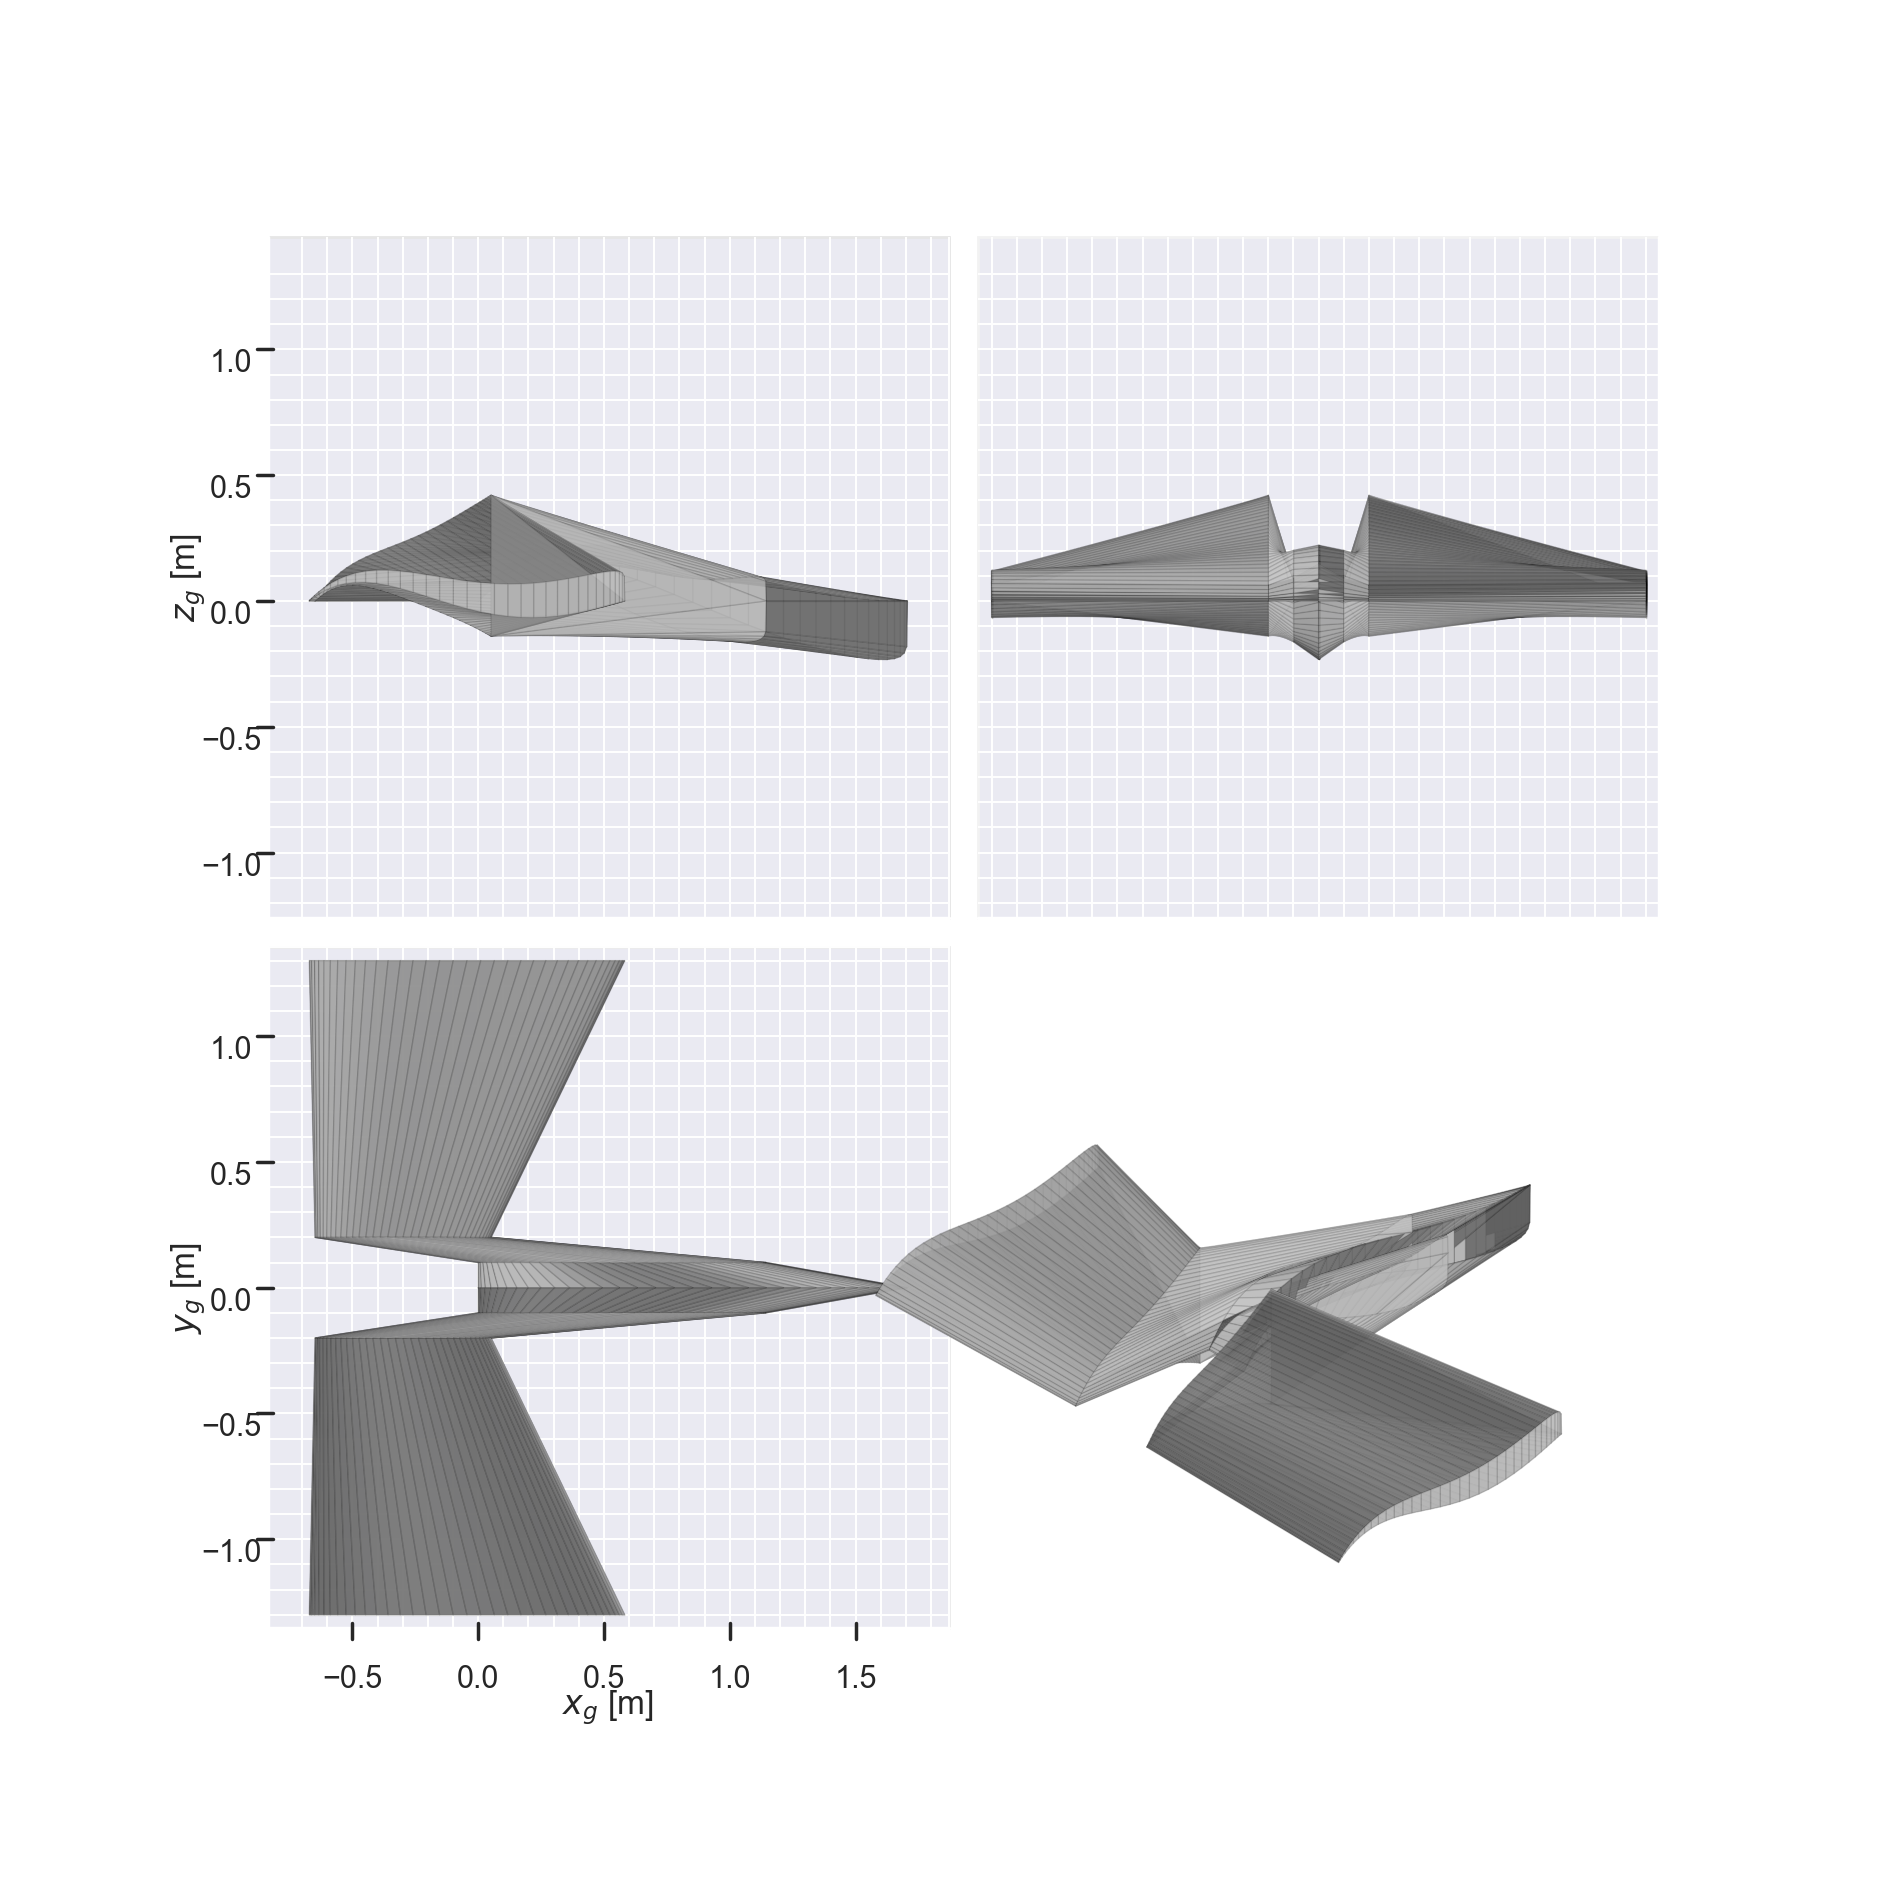

0

1

2

3

4

===

{'F_g': array([ 1.15660410e+09, -4.29559078e-03,  3.55191073e+08]), 'F_b': (-1156604098.0860574, 
-0.004295590781369995, -355191072.5222981), 'F_w': (-1156604098.0860574, -0.004295590781369995, 
-355191072.5222981), 'M_g': array([-2.12236465e-03,  1.01413957e+08,  7.91571889e-03]), 'M_b': 
(0.0021223646511840943, 101413956.78682369, -0.007915718891026324), 'M_w': (0.0021223646511840943, 
101413956.78682369, -0.007915718891026324), 'L': 355191072.5222981, 'D': 1156604098.0860574, 'Y': 
-0.004295590781369995, 'l_b': 0.0021223646511840943, 'm_b': 101413956.78682369, 'n_b': -0.007915718891026324, 'CL':
203613.79954587796, 'CD': 663024.9834526775, 'CY': -2.4624536705777802e-06, 'Cl': 1.766753034713255e-07, 'Cm': 
58579.0687594262, 'Cn': -6.58940506046184e-07}

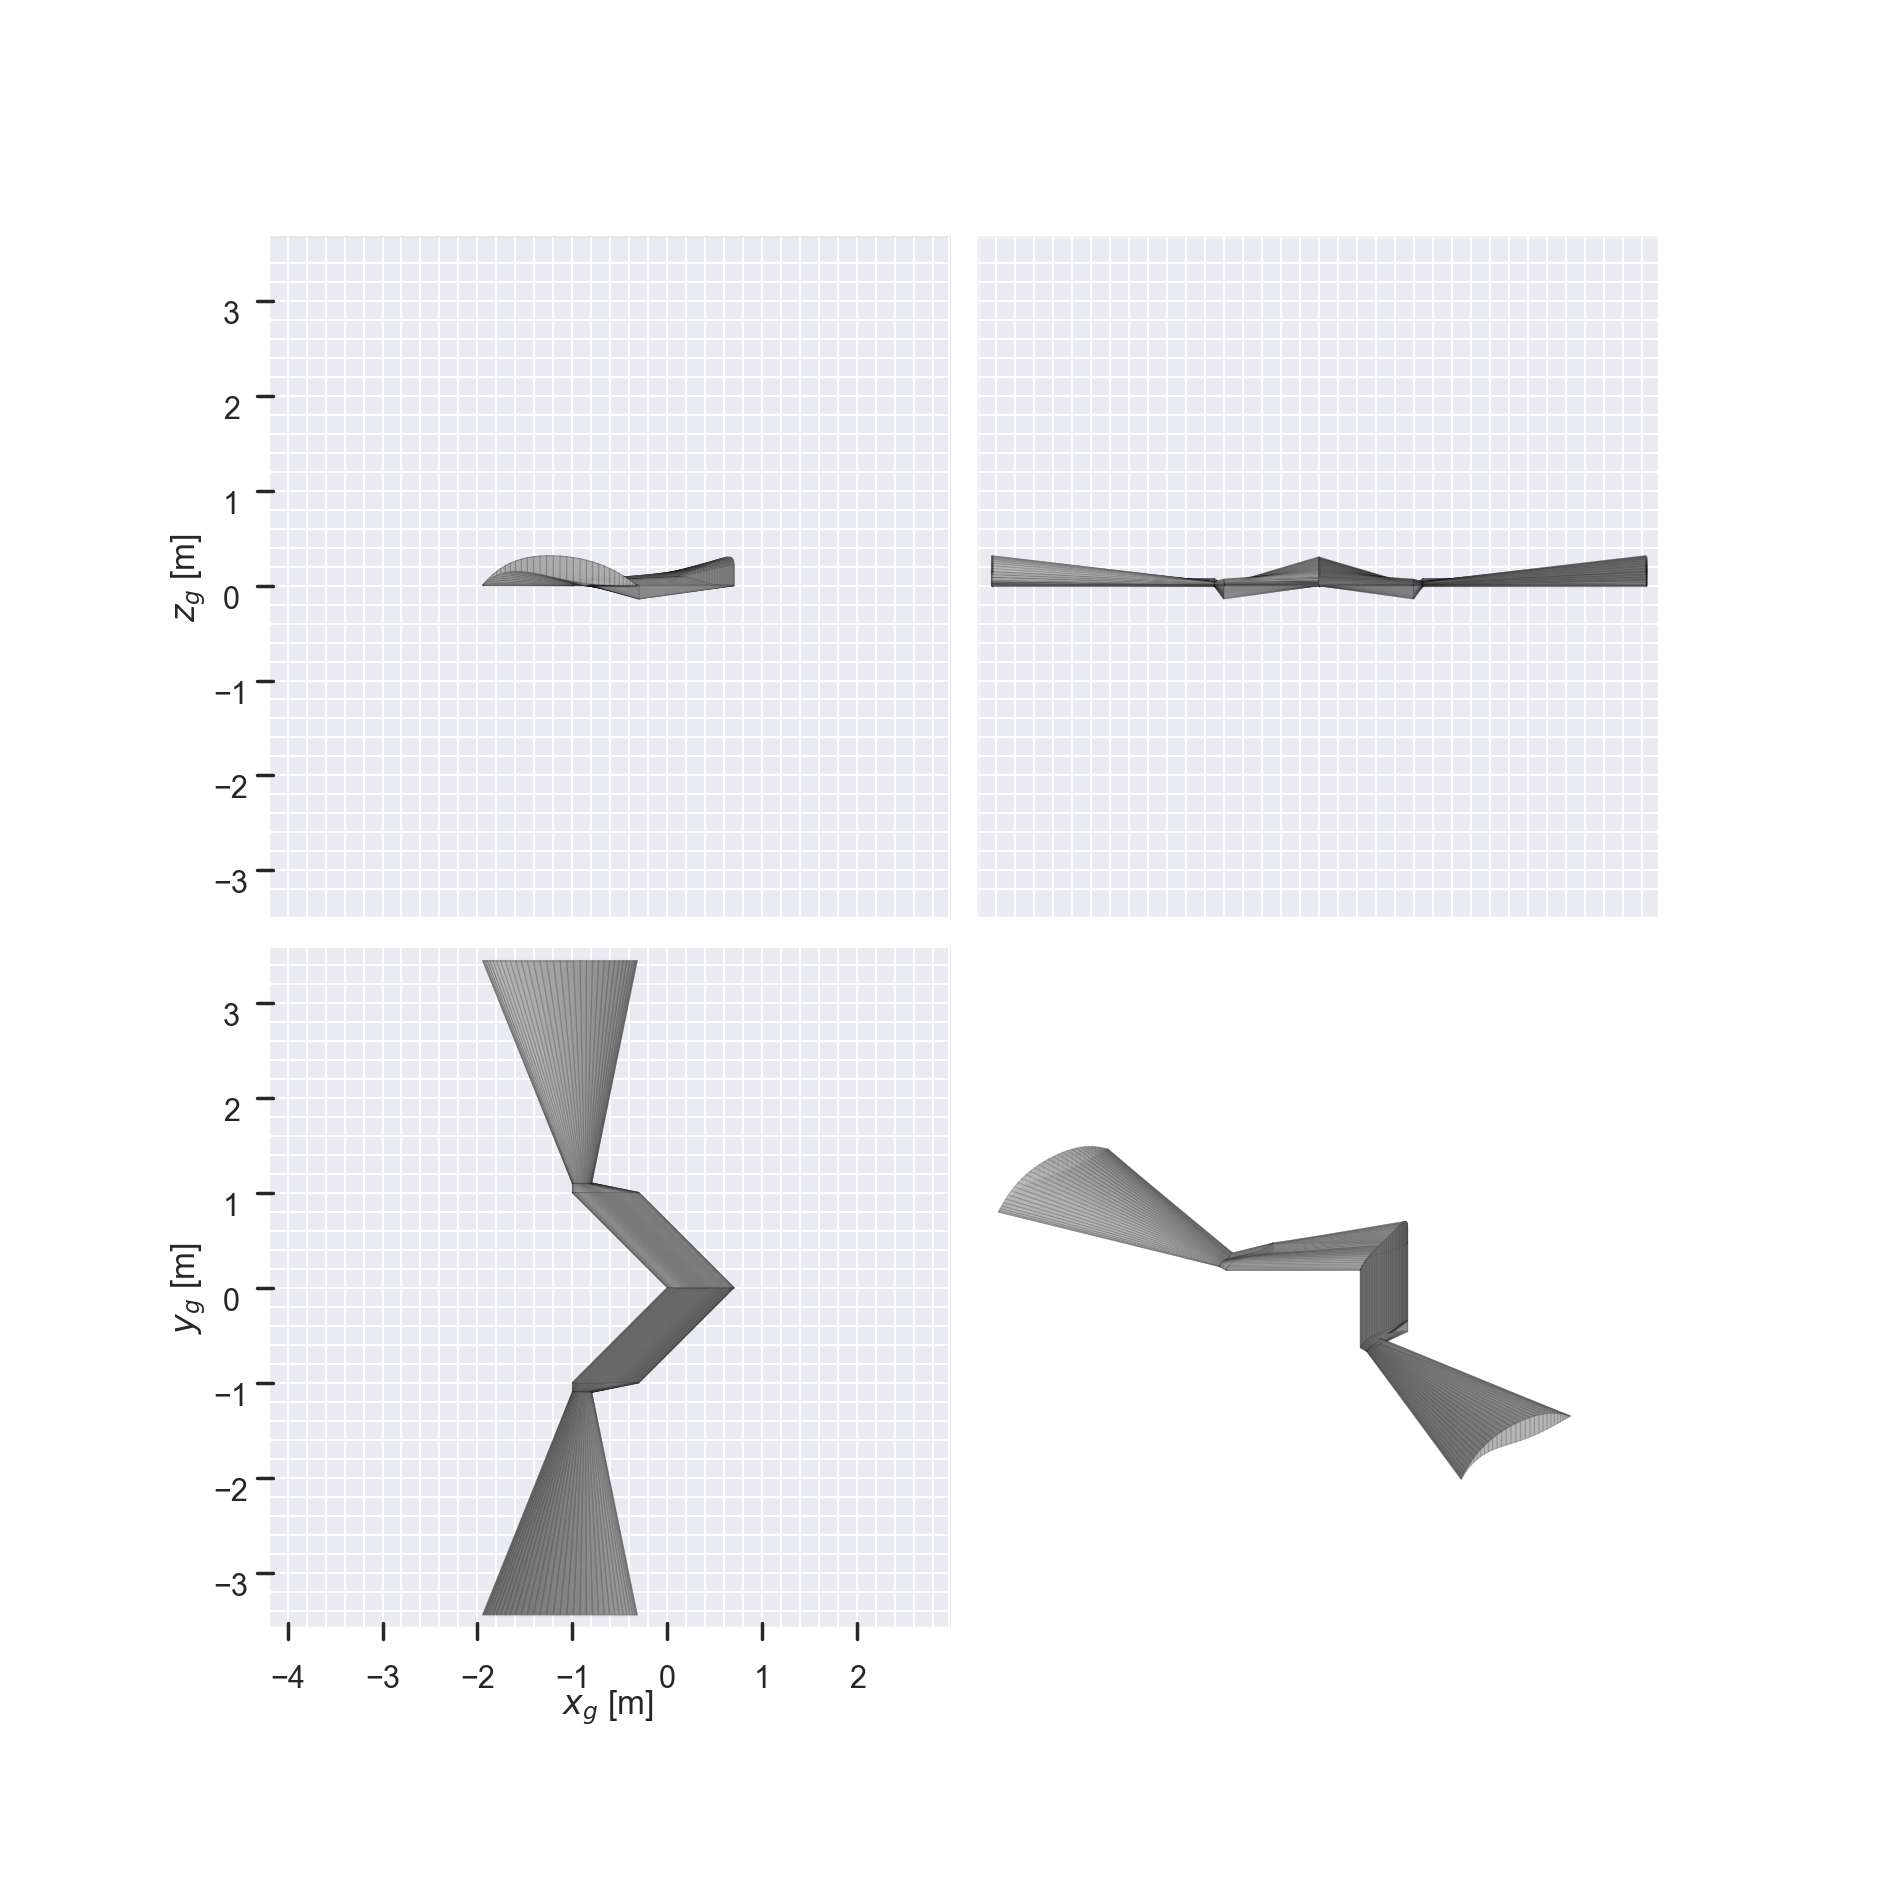

0

1

2

3

4

===

{'F_g': array([ 1.41226861e+13, -7.00912677e+02, -5.99275712e+12]), 'F_b': (-14122686087879.178, 
-700.9126766140666, 5992757120755.529), 'F_w': (-14122686087879.178, -700.9126766140666, 5992757120755.529), 'M_g':
array([ 3.93882797e+01,  5.81650158e+12, -6.13284685e+02]), 'M_b': (-39.3882797333262, 5816501579231.841, 
613.2846845780407), 'M_w': (-39.3882797333262, 5816501579231.841, 613.2846845780407), 'L': -5992757120755.529, 'D':
14122686087879.178, 'Y': -700.9126766140666, 'l_b': -39.3882797333262, 'm_b': 5816501579231.841, 'n_b': 
613.2846845780407, 'CL': -6681412425.879677, 'CD': 15745588952.294754, 'CY': -0.7814577785517519, 'Cl': 
-0.021187982291917876, 'Cm': 4279971771.2377586, 'Cn': 0.3299018165992558}

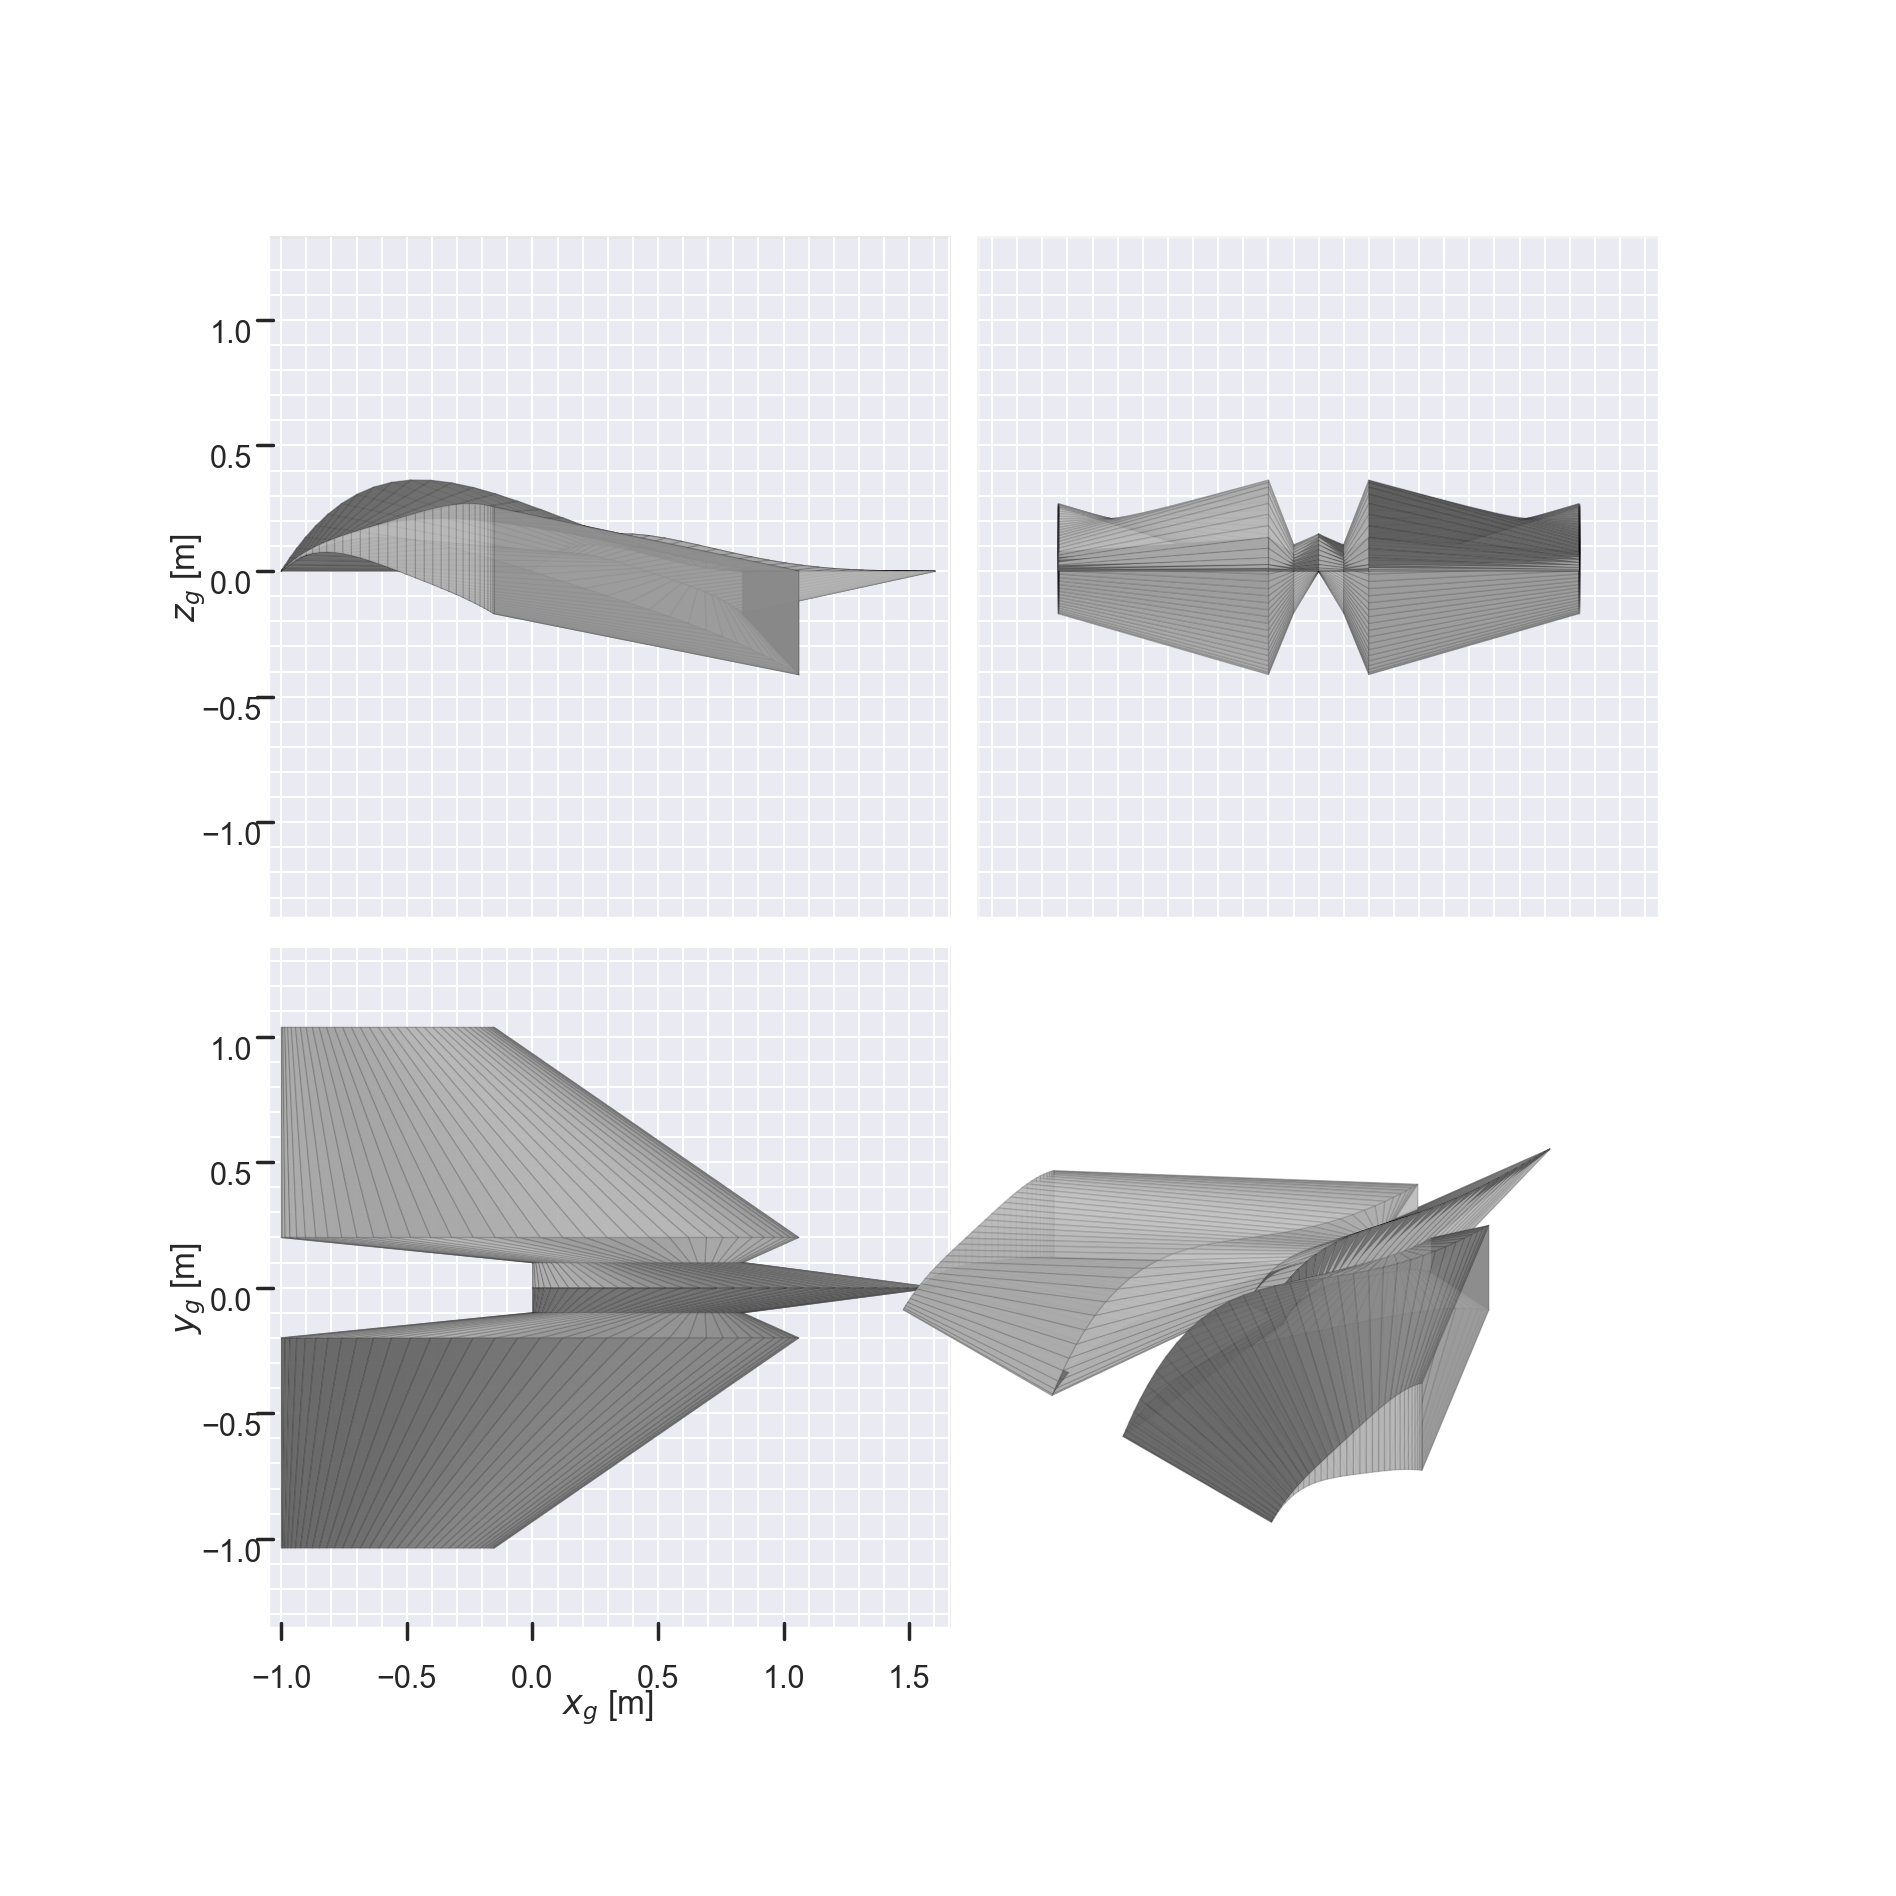

0

1

2

3

4

===

{'F_g': array([ 2.77308453e+10,  1.08127050e+00, -1.30802773e+11]), 'F_b': (-27730845343.99695, 1.0812705012212973,
130802772861.24661), 'F_w': (-27730845343.99695, 1.0812705012212973, 130802772861.24661), 'M_g': 
array([-1.31449353e+00,  1.26159045e+11,  8.14006820e-01]), 'M_b': (1.3144935305281251, 126159044736.23135, 
-0.8140068202046677), 'M_w': (1.3144935305281251, 126159044736.23135, -0.8140068202046677), 'L': 
-130802772861.24661, 'D': 27730845343.99695, 'Y': 1.0812705012212973, 'l_b': 1.3144935305281251, 'm_b': 
126159044736.23135, 'n_b': -0.8140068202046677, 'CL': -68577671.0374637, 'CD': 14538810.974662699, 'CY': 
0.0005668917494121151, 'Cl': 0.0001566287773735365, 'Cm': 36970784.93404392, 'Cn': -9.699316889840661e-05}

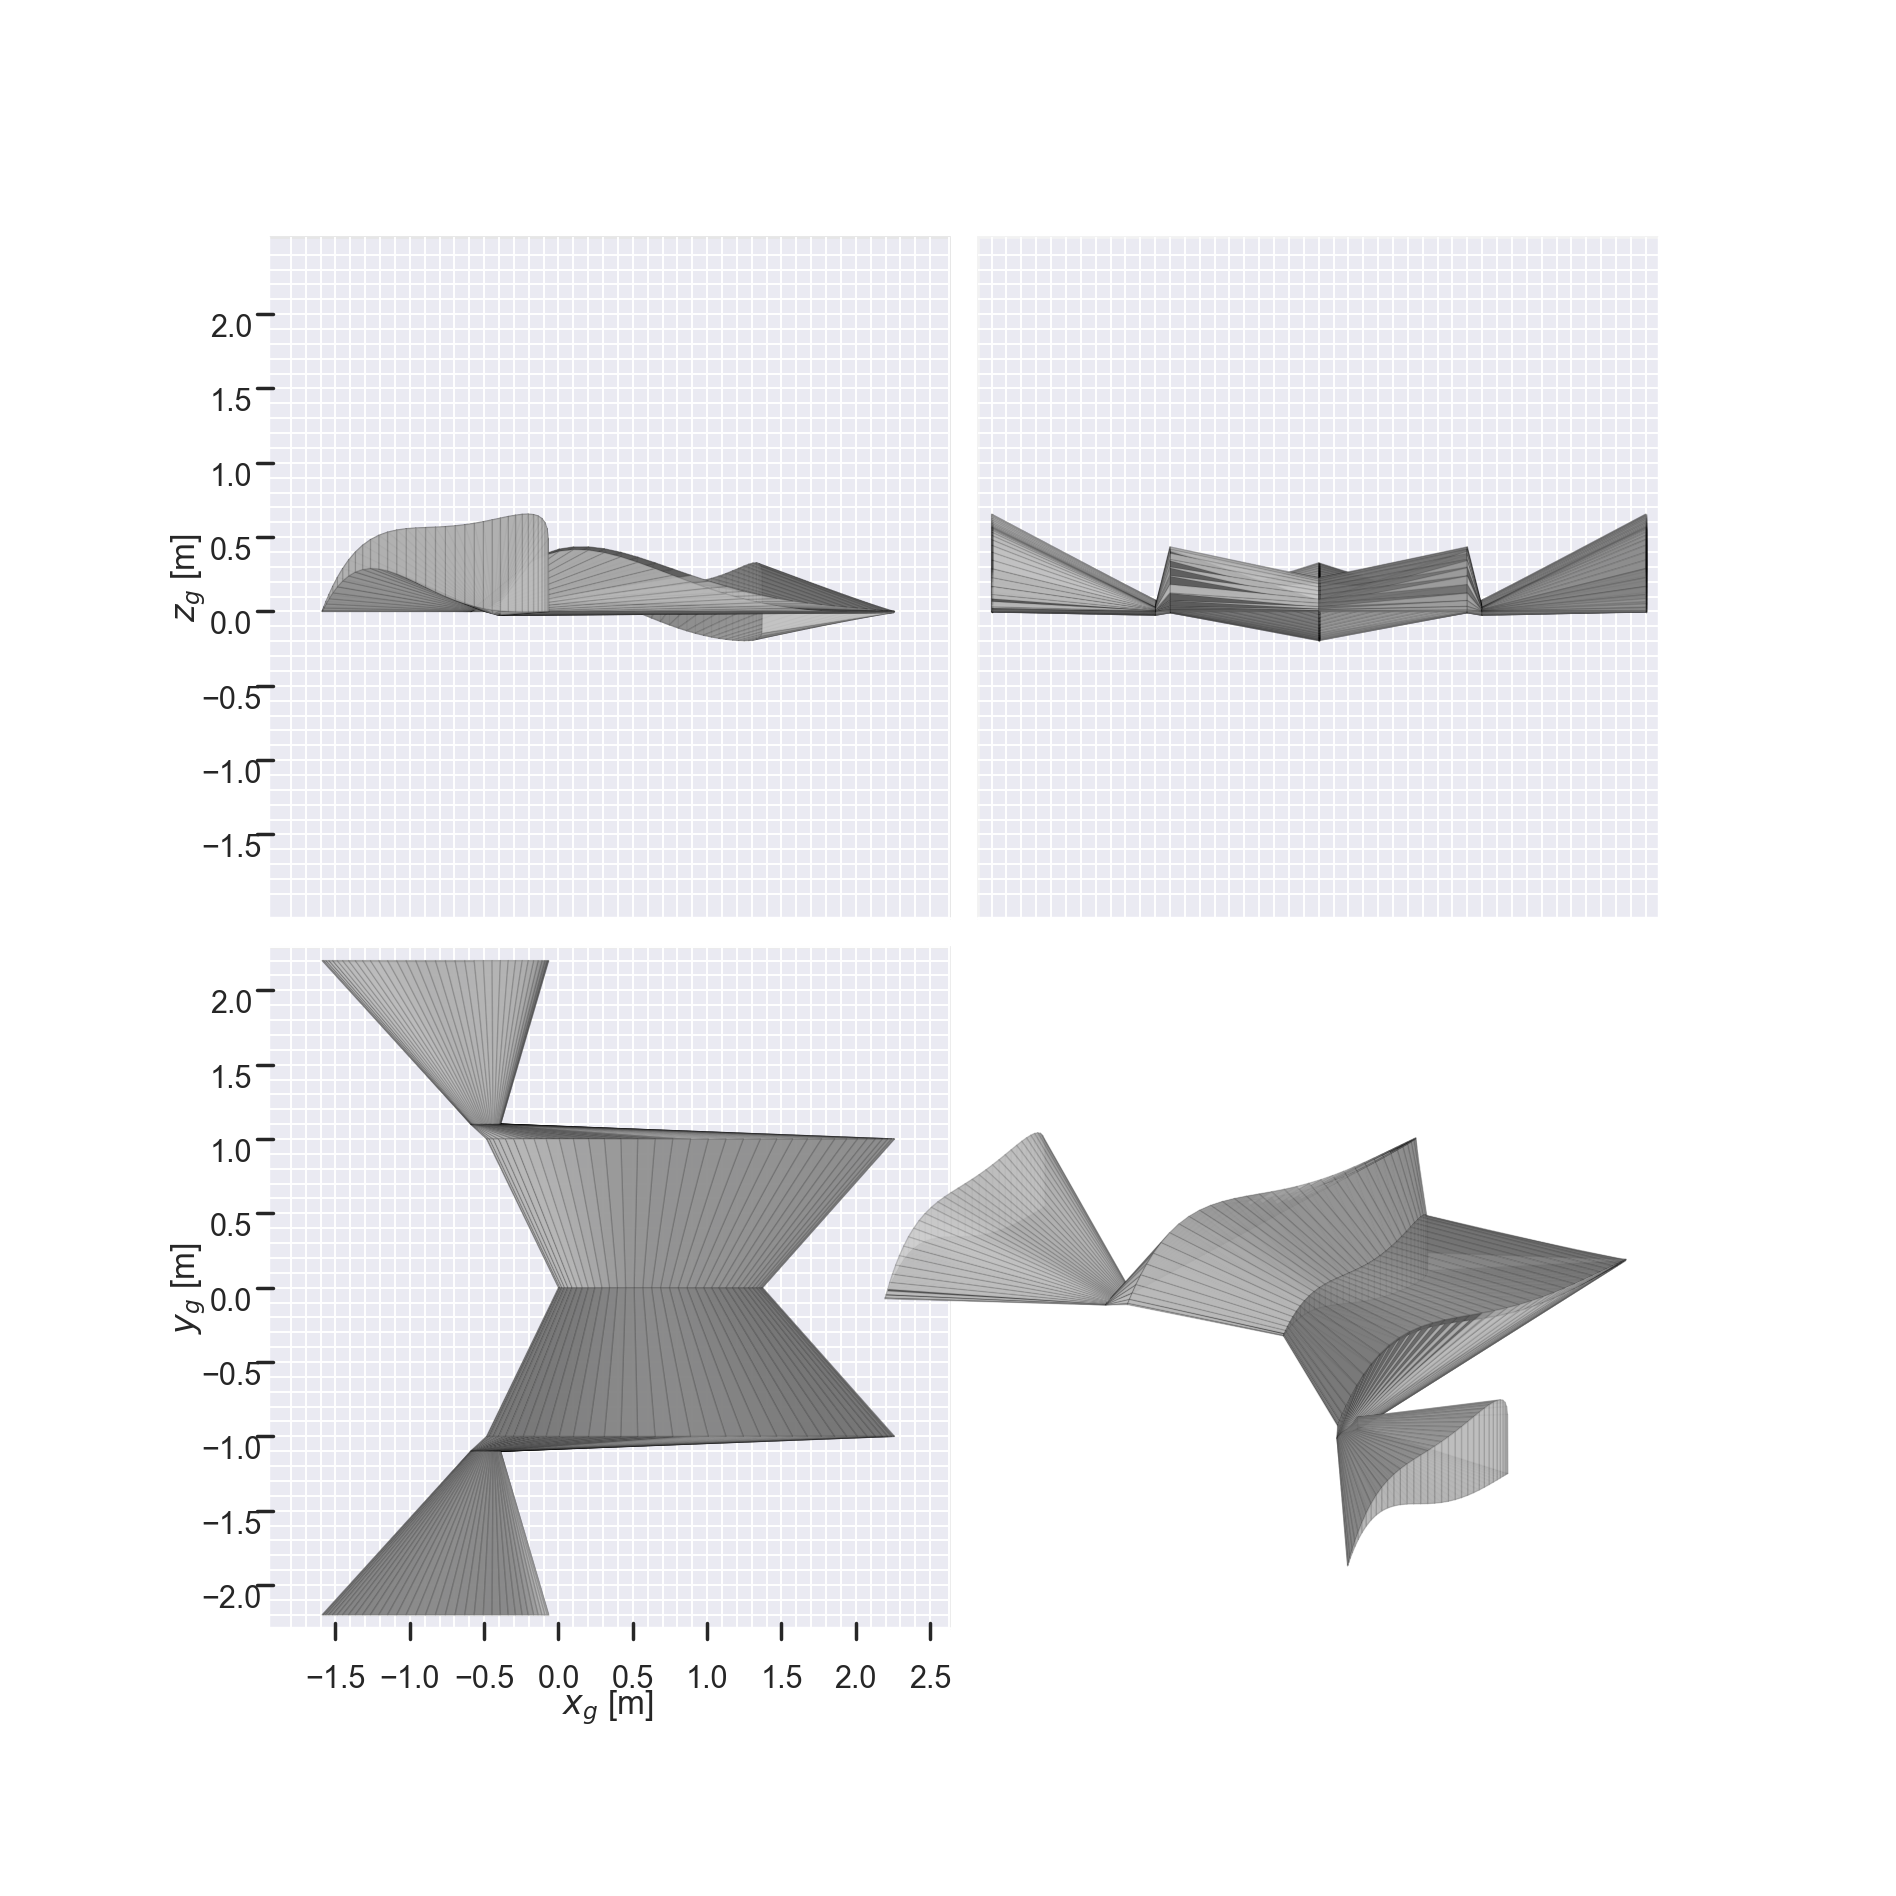

0

1

2

3

4

===

{'F_g': array([ 5.22264369e+10, -1.86991354e-03, -4.51879435e+10]), 'F_b': (-52226436858.50347, 
-0.001869913539970014, 45187943500.390175), 'F_w': (-52226436858.50347, -0.001869913539970014, 45187943500.390175),
'M_g': array([-5.53024927e-04,  2.15971636e+10, -1.85495715e-03]), 'M_b': (0.0005530249267677867, 
21597163559.12902, 0.0018549571467740833), 'M_w': (0.0005530249267677867, 21597163559.12902, 
0.0018549571467740833), 'L': -45187943500.390175, 'D': 52226436858.50347, 'Y': -0.001869913539970014, 'l_b': 
0.0005530249267677867, 'm_b': 21597163559.12902, 'n_b': 0.0018549571467740833, 'CL': -176464833.9425168, 'CD': 
203951071.76243988, 'CY': -7.30225712340335e-06, 'Cl': 1.8908046462145637e-06, 'Cm': 86803859.75084402, 'Cn': 
6.342140149357275e-06}

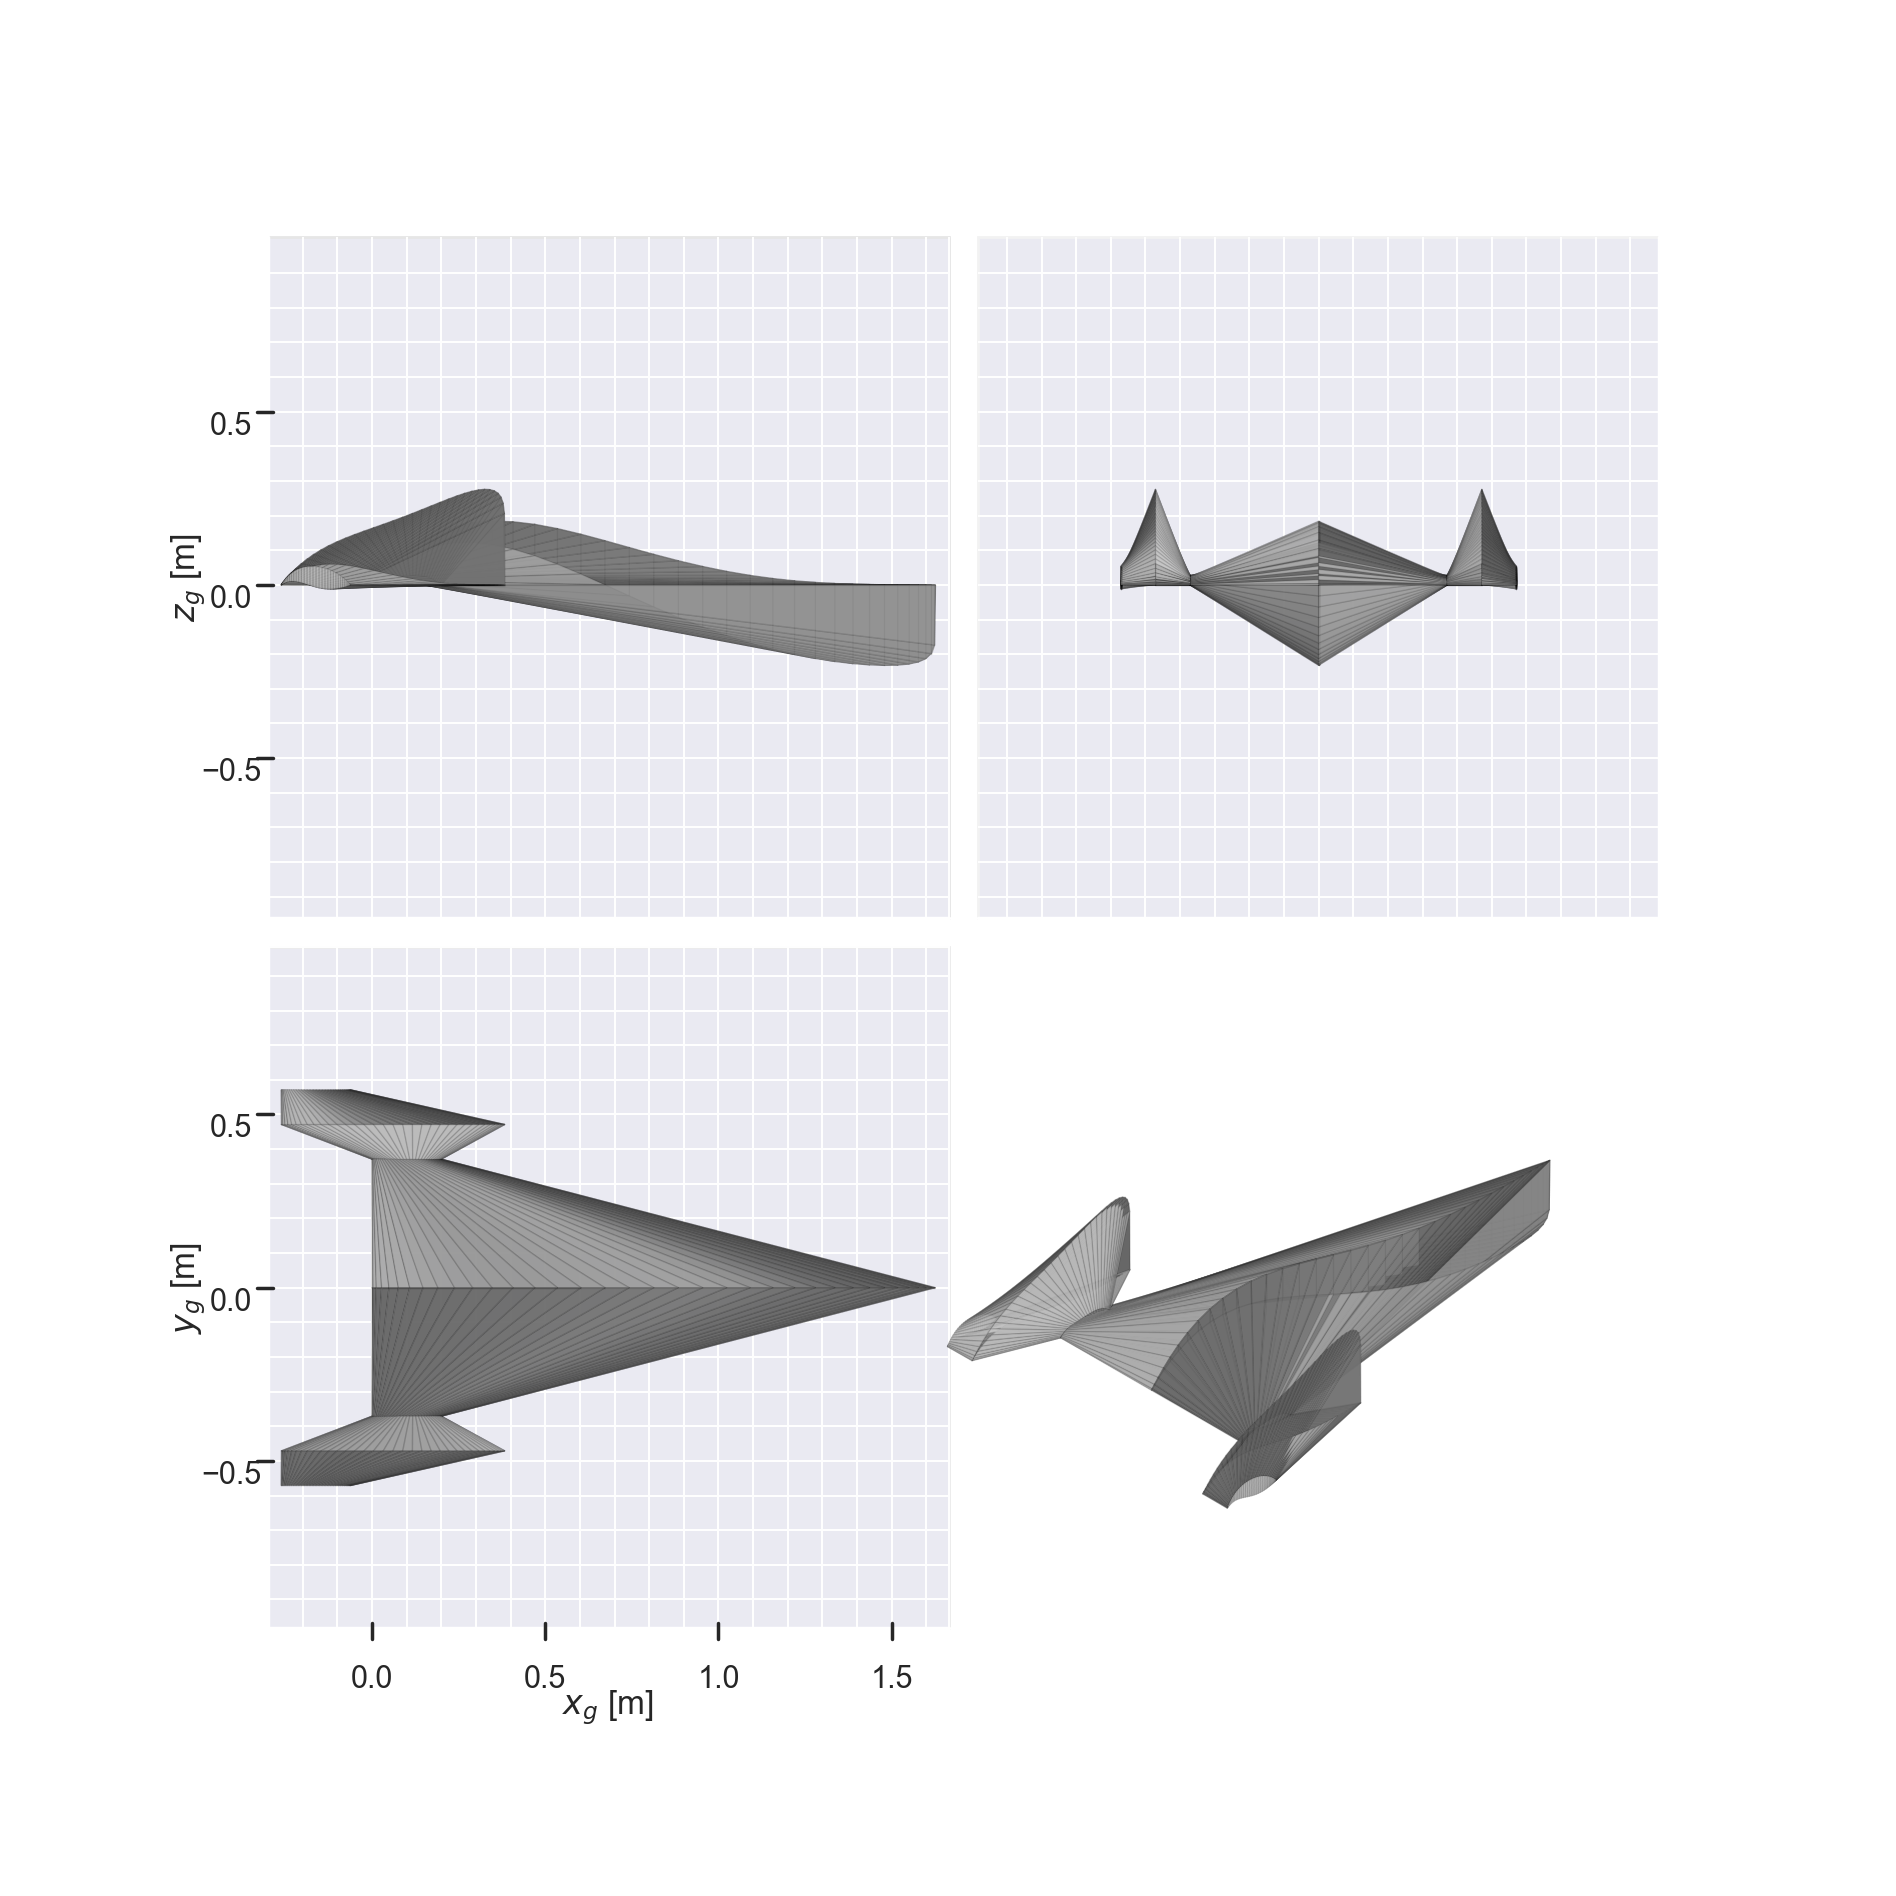

0

1

2

3

4

===

{'F_g': array([ 1.20550076e+10, -1.06358456e-01,  8.16094034e+10]), 'F_b': (-12055007647.793661, 
-0.106358456430371, -81609403369.6347), 'F_w': (-12055007647.793661, -0.106358456430371, -81609403369.6347), 'M_g':
array([-2.33827926e-02, -3.78122455e+09, -5.66095415e-03]), 'M_b': (0.0233827926331287, -3781224547.63541, 
0.005660954149789177), 'M_w': (0.0233827926331287, -3781224547.63541, 0.005660954149789177), 'L': 81609403369.6347,
'D': 12055007647.793661, 'Y': -0.106358456430371, 'l_b': 0.0233827926331287, 'm_b': -3781224547.63541, 'n_b': 
0.005660954149789177, 'CL': 31827280.677473947, 'CD': 4701395.870248245, 'CY': -4.14792941188421e-05, 'Cl': 
1.3745227400300627e-06, 'Cm': -1118369.218460118, 'Cn': 3.327707828246533e-07}

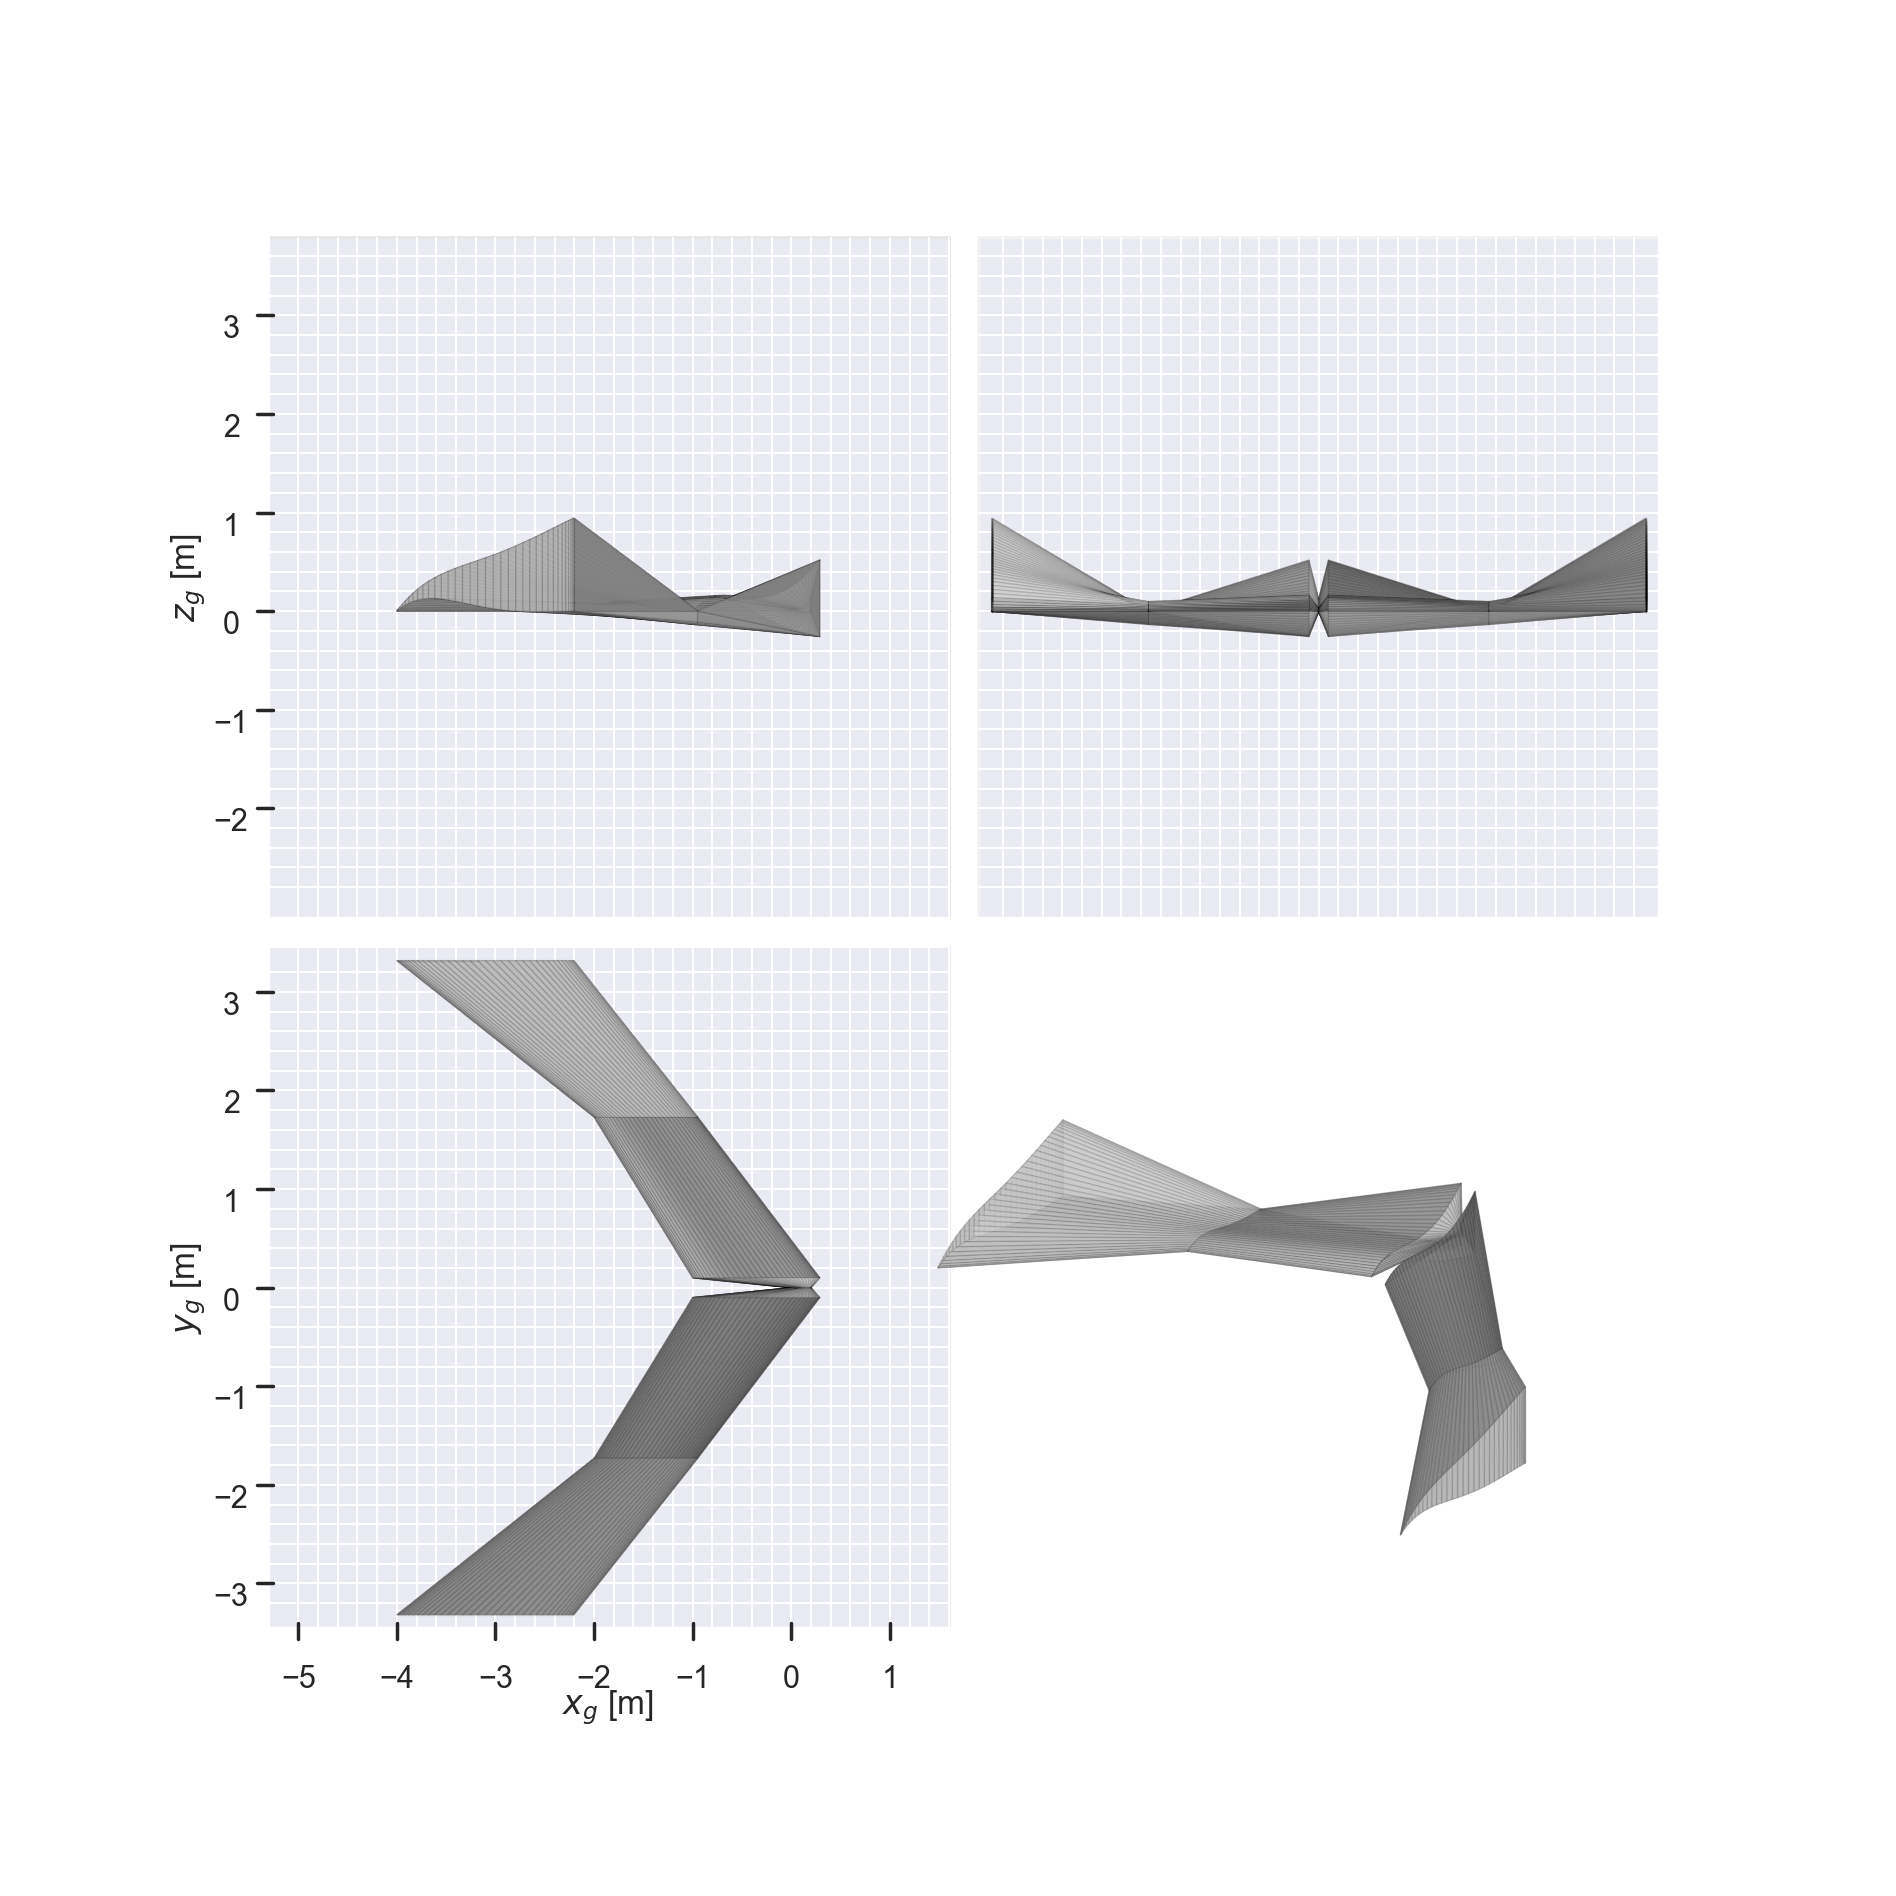

0

1

2

3

4

===

{'F_g': array([2.32683925e+02, 2.27373675e-13, 2.39299886e+03]), 'F_b': (-232.68392532396294, 
2.2737367544323206e-13, -2392.998860811728), 'F_w': (-232.68392532396294, 2.2737367544323206e-13, 
-2392.998860811728), 'M_g': array([ 6.53699317e-13, -2.23884871e+02, -2.27373675e-13]), 'M_b': 
(-6.536993168992922e-13, -223.8848708448861, 2.2737367544323206e-13), 'M_w': (-6.536993168992922e-13, 
-223.8848708448861, 2.2737367544323206e-13), 'L': 2392.998860811728, 'D': 232.68392532396294, 'Y': 
2.2737367544323206e-13, 'l_b': -6.536993168992922e-13, 'm_b': -223.8848708448861, 'n_b': 2.2737367544323206e-13, 
'CL': 0.6924770243288005, 'CD': 0.06733320055272674, 'CY': 6.579654038289968e-17, 'Cl': -2.1215967416017164e-17, 
'Cm': -0.047232140507191885, 'Cn': 7.379466927310317e-18}

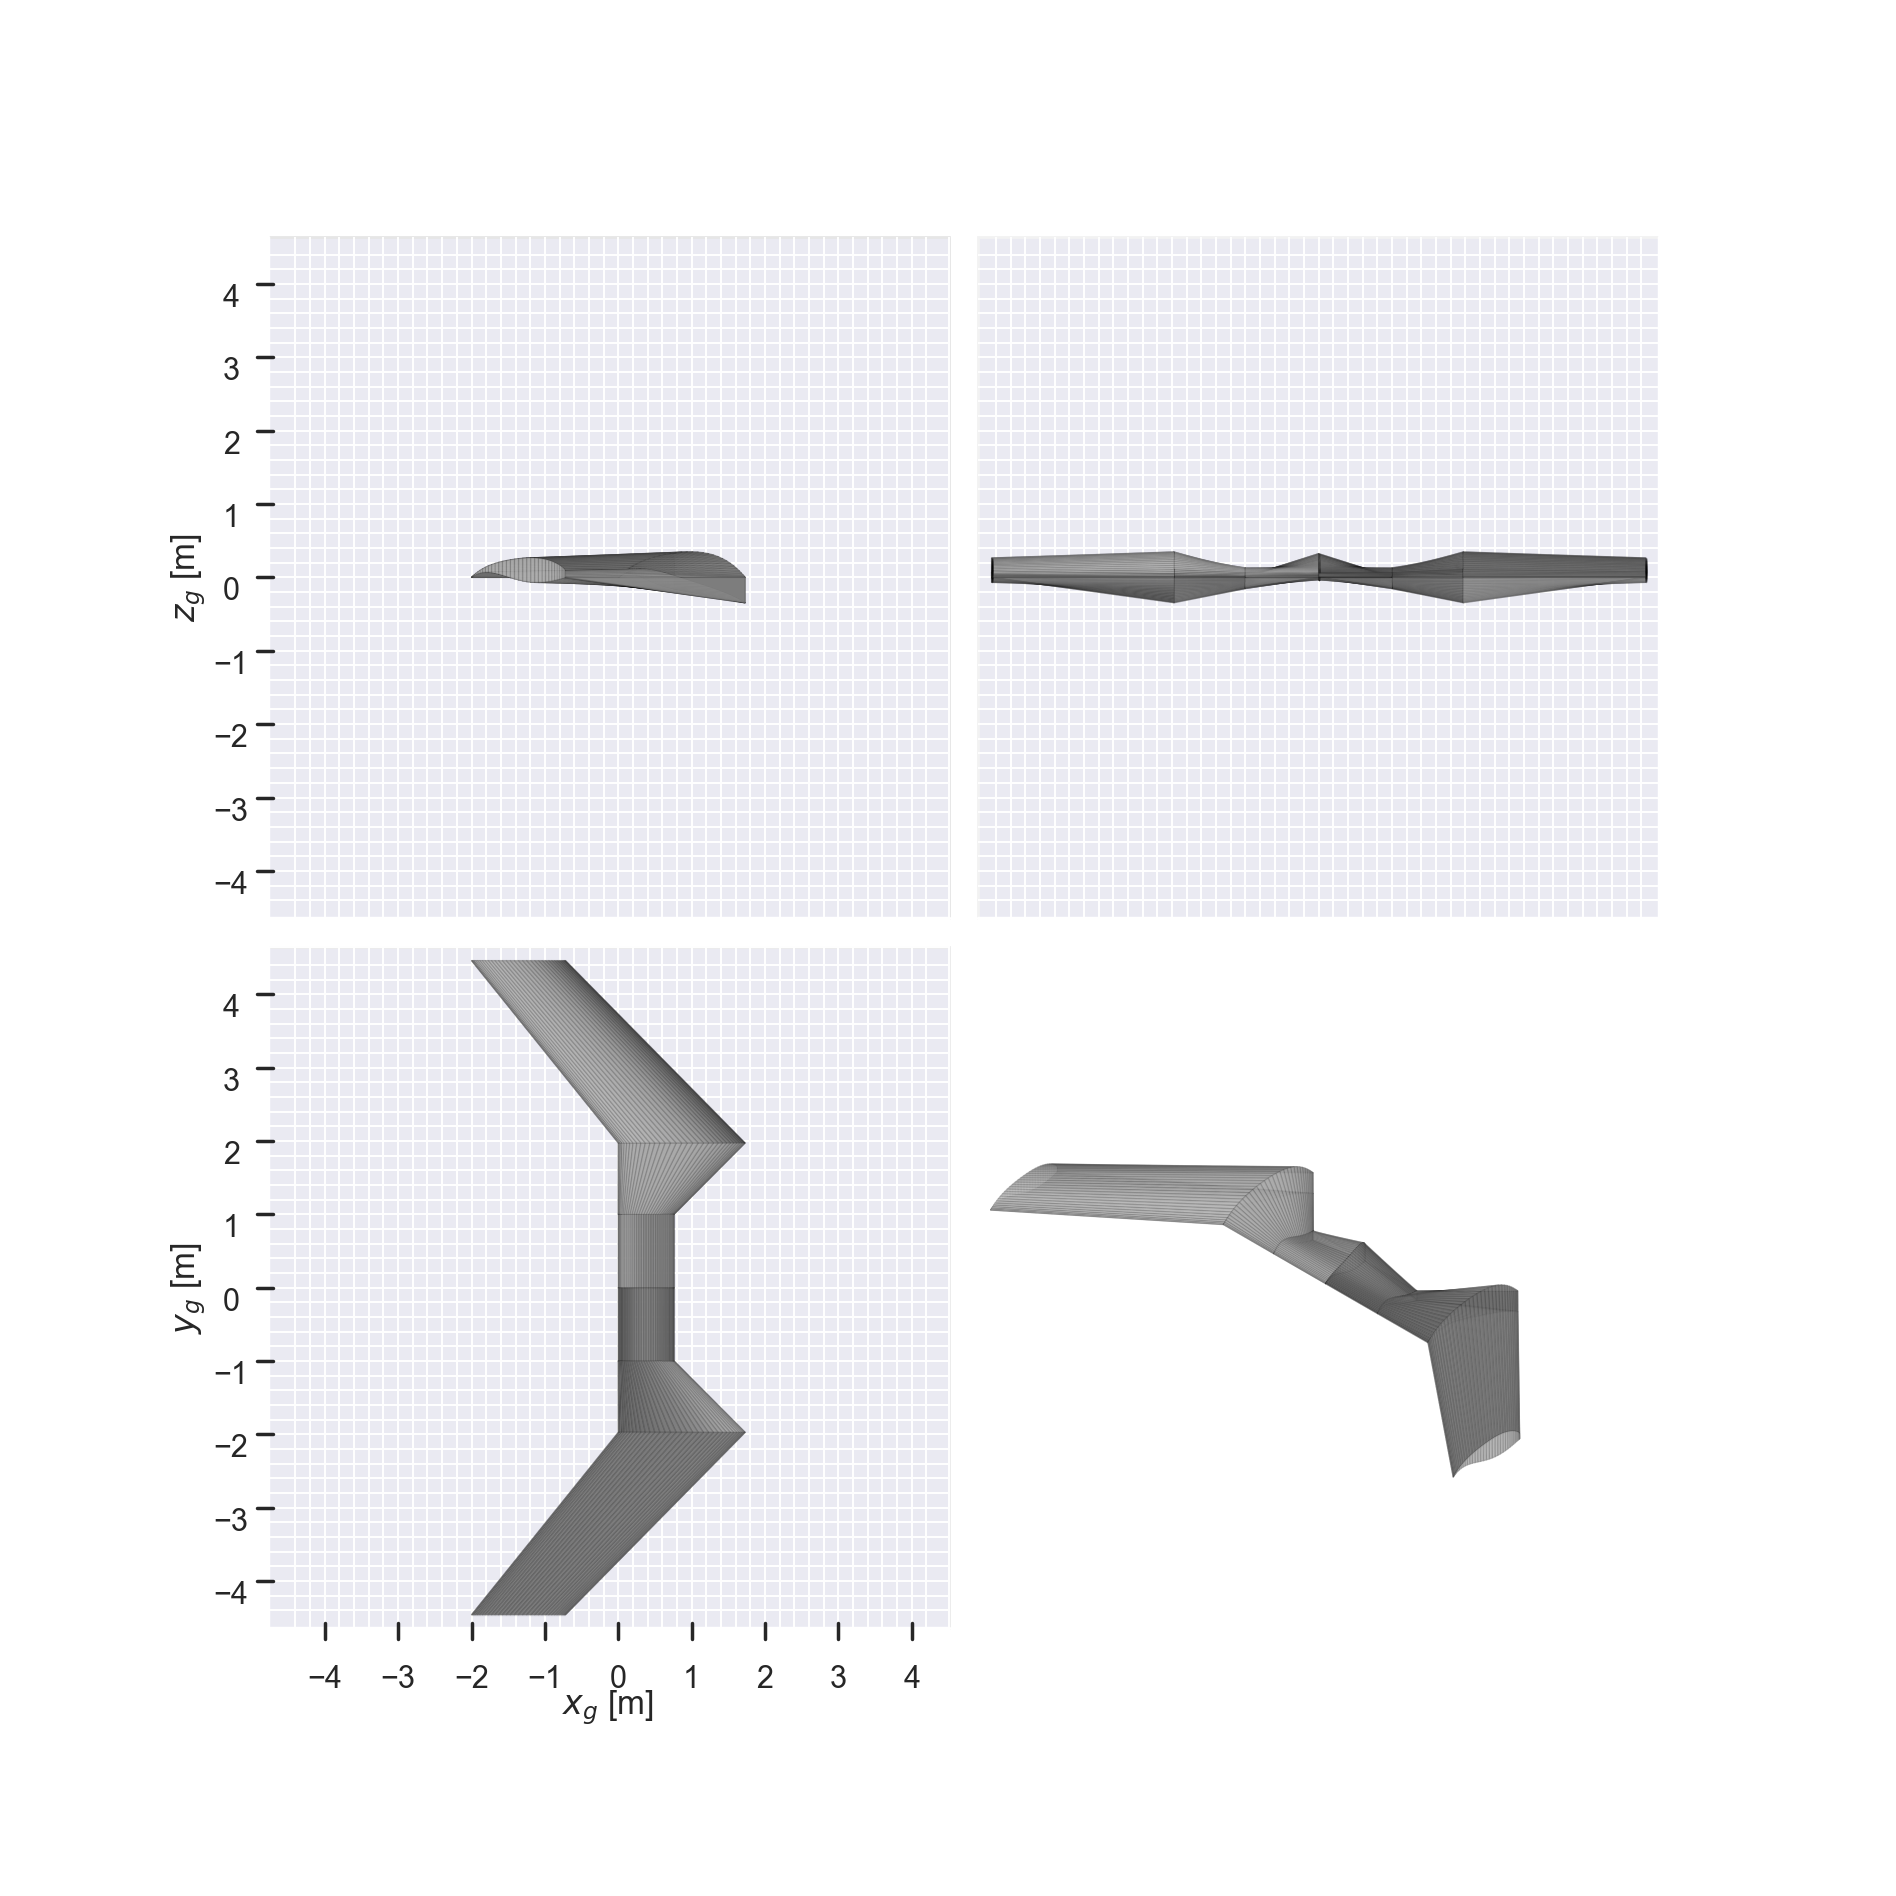

0

1

2

3

4

===

{'F_g': array([ 3.14962564e+13,  2.17598815e+03, -3.12889846e+14]), 'F_b': (-31496256407702.117, 
2175.9881452193767, 312889845981773.3), 'F_w': (-31496256407702.117, 2175.9881452193767, 312889845981773.3), 'M_g':
array([-1.20750277e+03,  1.06404964e+14,  8.16503256e+02]), 'M_b': (1207.5027737459245, 106404963825228.75, 
-816.503255677424), 'M_w': (1207.5027737459245, 106404963825228.75, -816.503255677424), 'L': -312889845981773.3, 
'D': 31496256407702.117, 'Y': 2175.9881452193767, 'l_b': 1207.5027737459245, 'm_b': 106404963825228.75, 'n_b': 
-816.503255677424, 'CL': -153734439679.95773, 'CD': 15475284331.011581, 'CY': 1.0691440535753862, 'Cl': 
0.11242262525988751, 'Cm': 33702046400.12094, 'Cn': -0.07601923700078869}

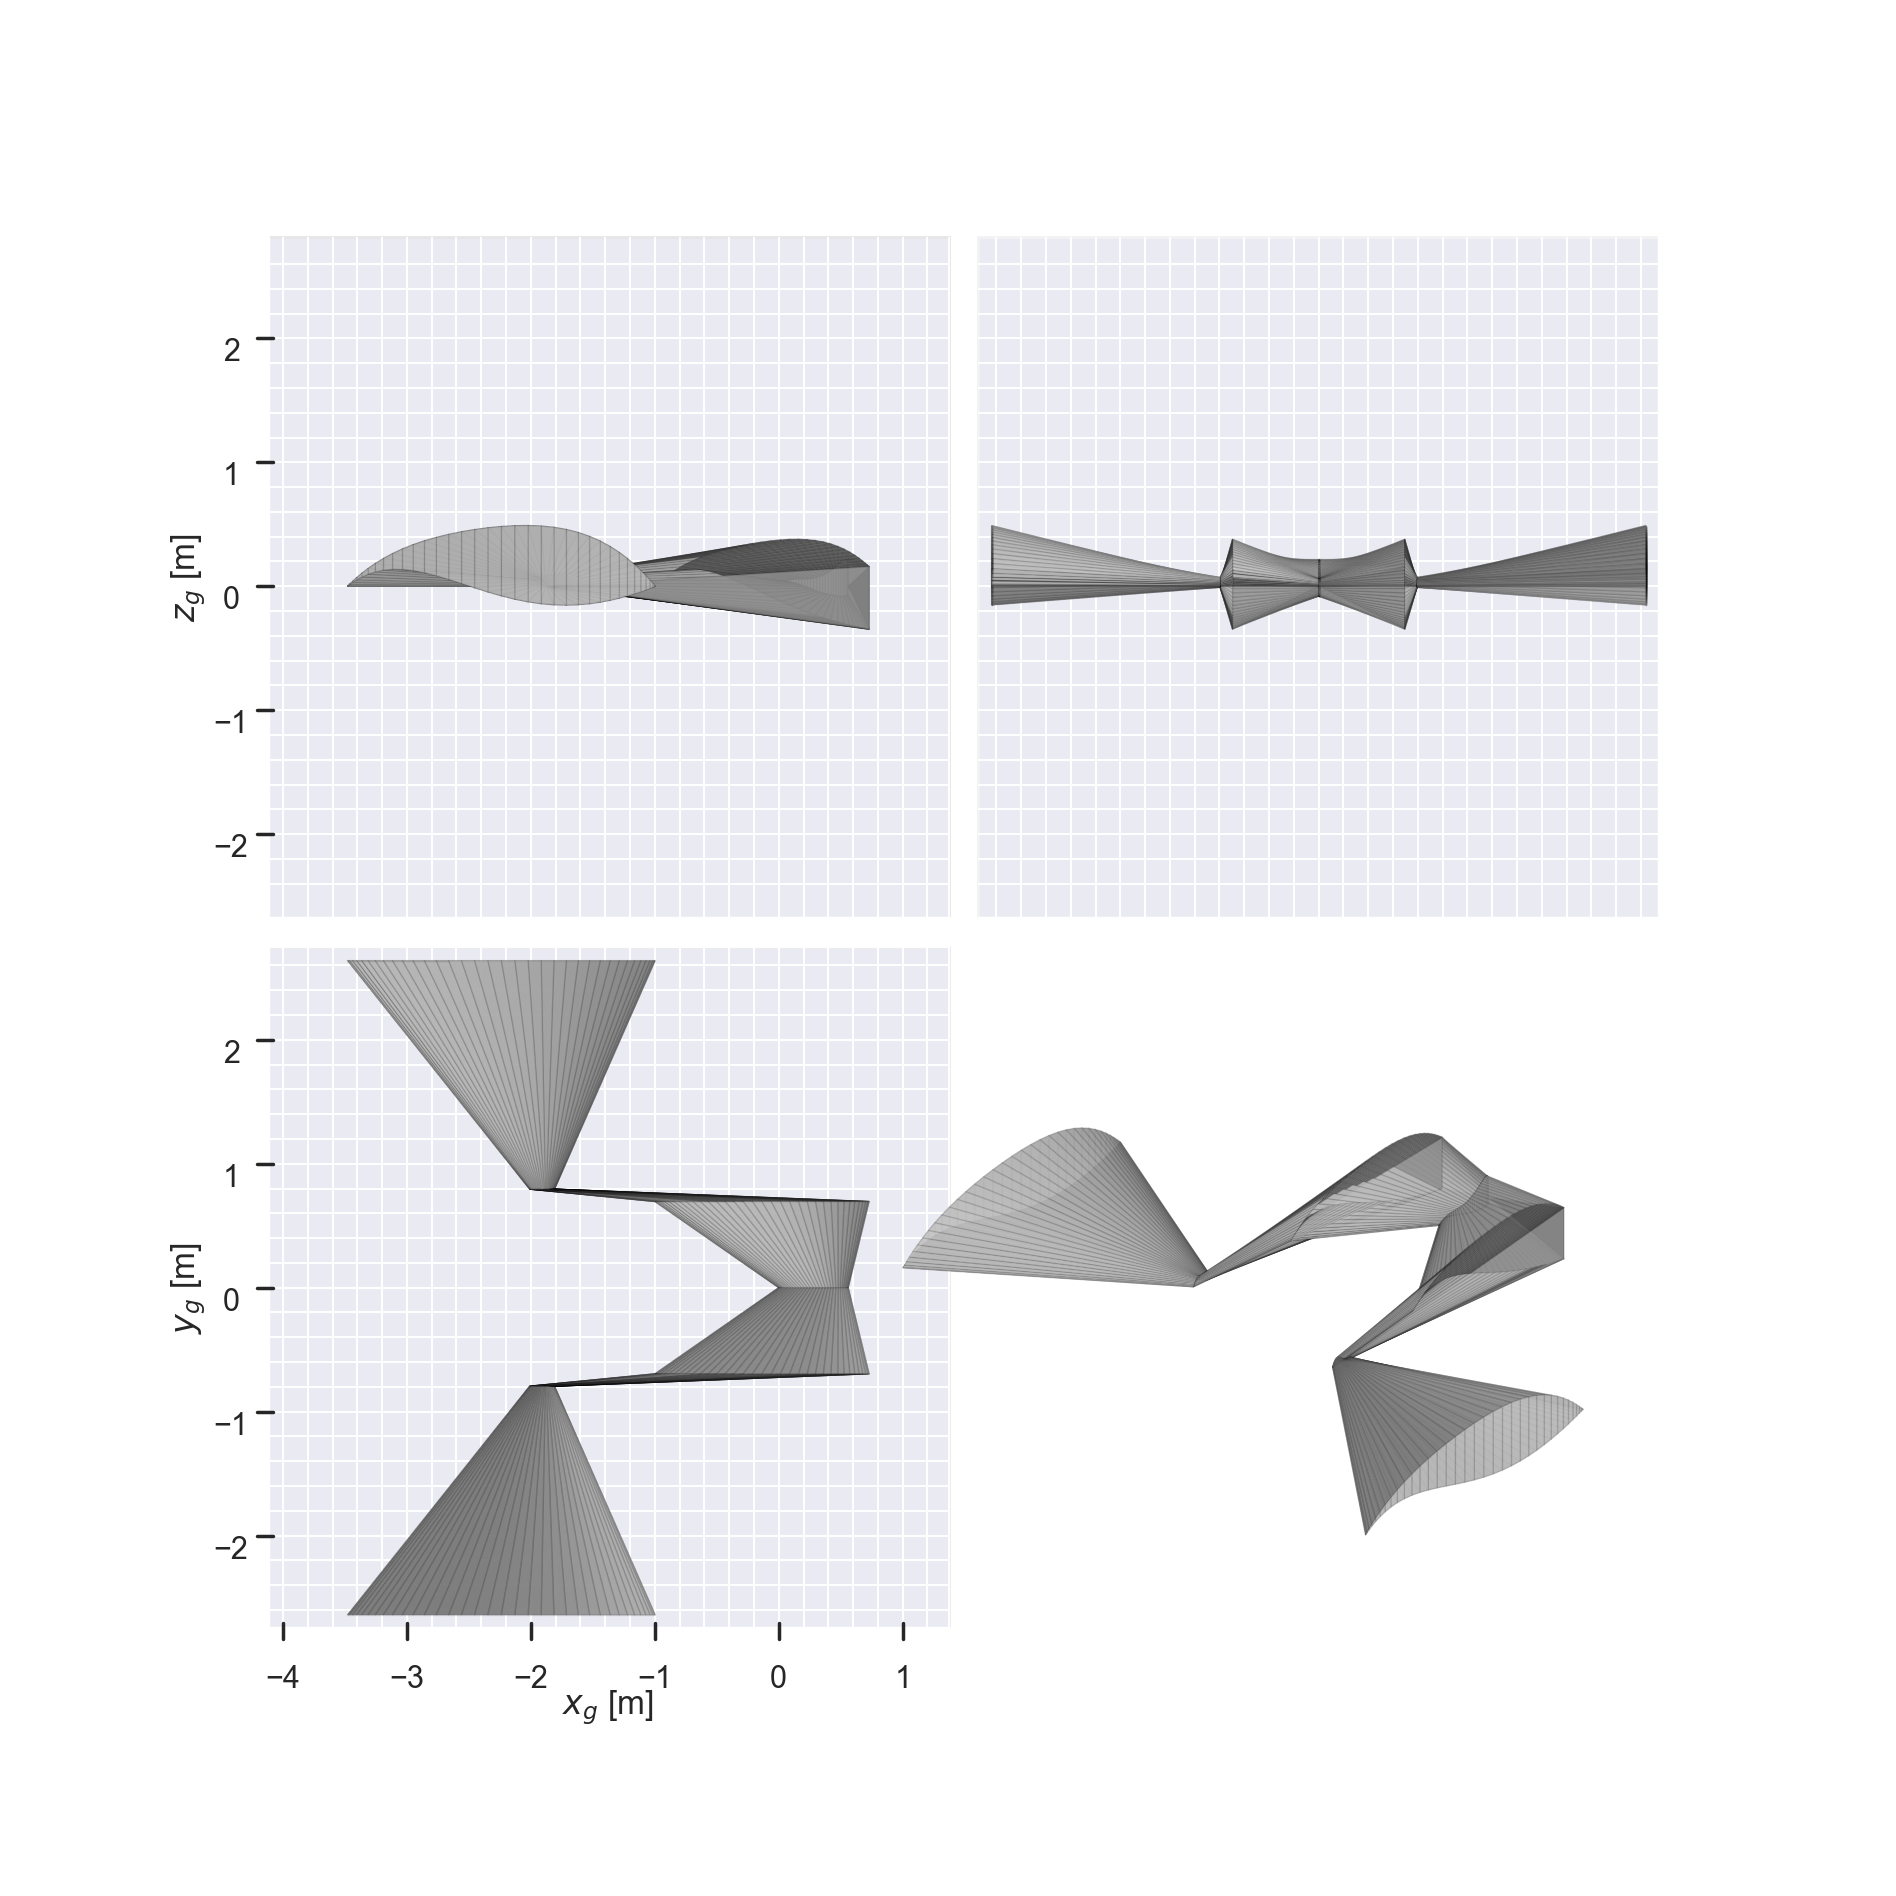

0

1

2

3

4

===

{'F_g': array([4.41893862e+11, 2.14044516e+03, 5.49269143e+11]), 'F_b': (-441893861931.8049, 2140.445163902237, 
-549269142733.6166), 'F_w': (-441893861931.8049, 2140.445163902237, -549269142733.6166), 'M_g': array([ 
3.94775272e+01, -3.16390265e+10,  9.39152823e+01]), 'M_b': (-39.47752716923688, -31639026480.007767, 
-93.915282311091), 'M_w': (-39.47752716923688, -31639026480.007767, -93.915282311091), 'L': 549269142733.6166, 'D':
441893861931.8049, 'Y': 2140.445163902237, 'l_b': -39.47752716923688, 'm_b': -31639026480.007767, 'n_b': 
-93.915282311091, 'CL': 944477146.2191297, 'CD': 759843619.7816976, 'CY': 3.680529967475988, 'Cl': 
-0.029675761827083216, 'Cm': -58272259.92511794, 'Cn': -0.07059731826260414}

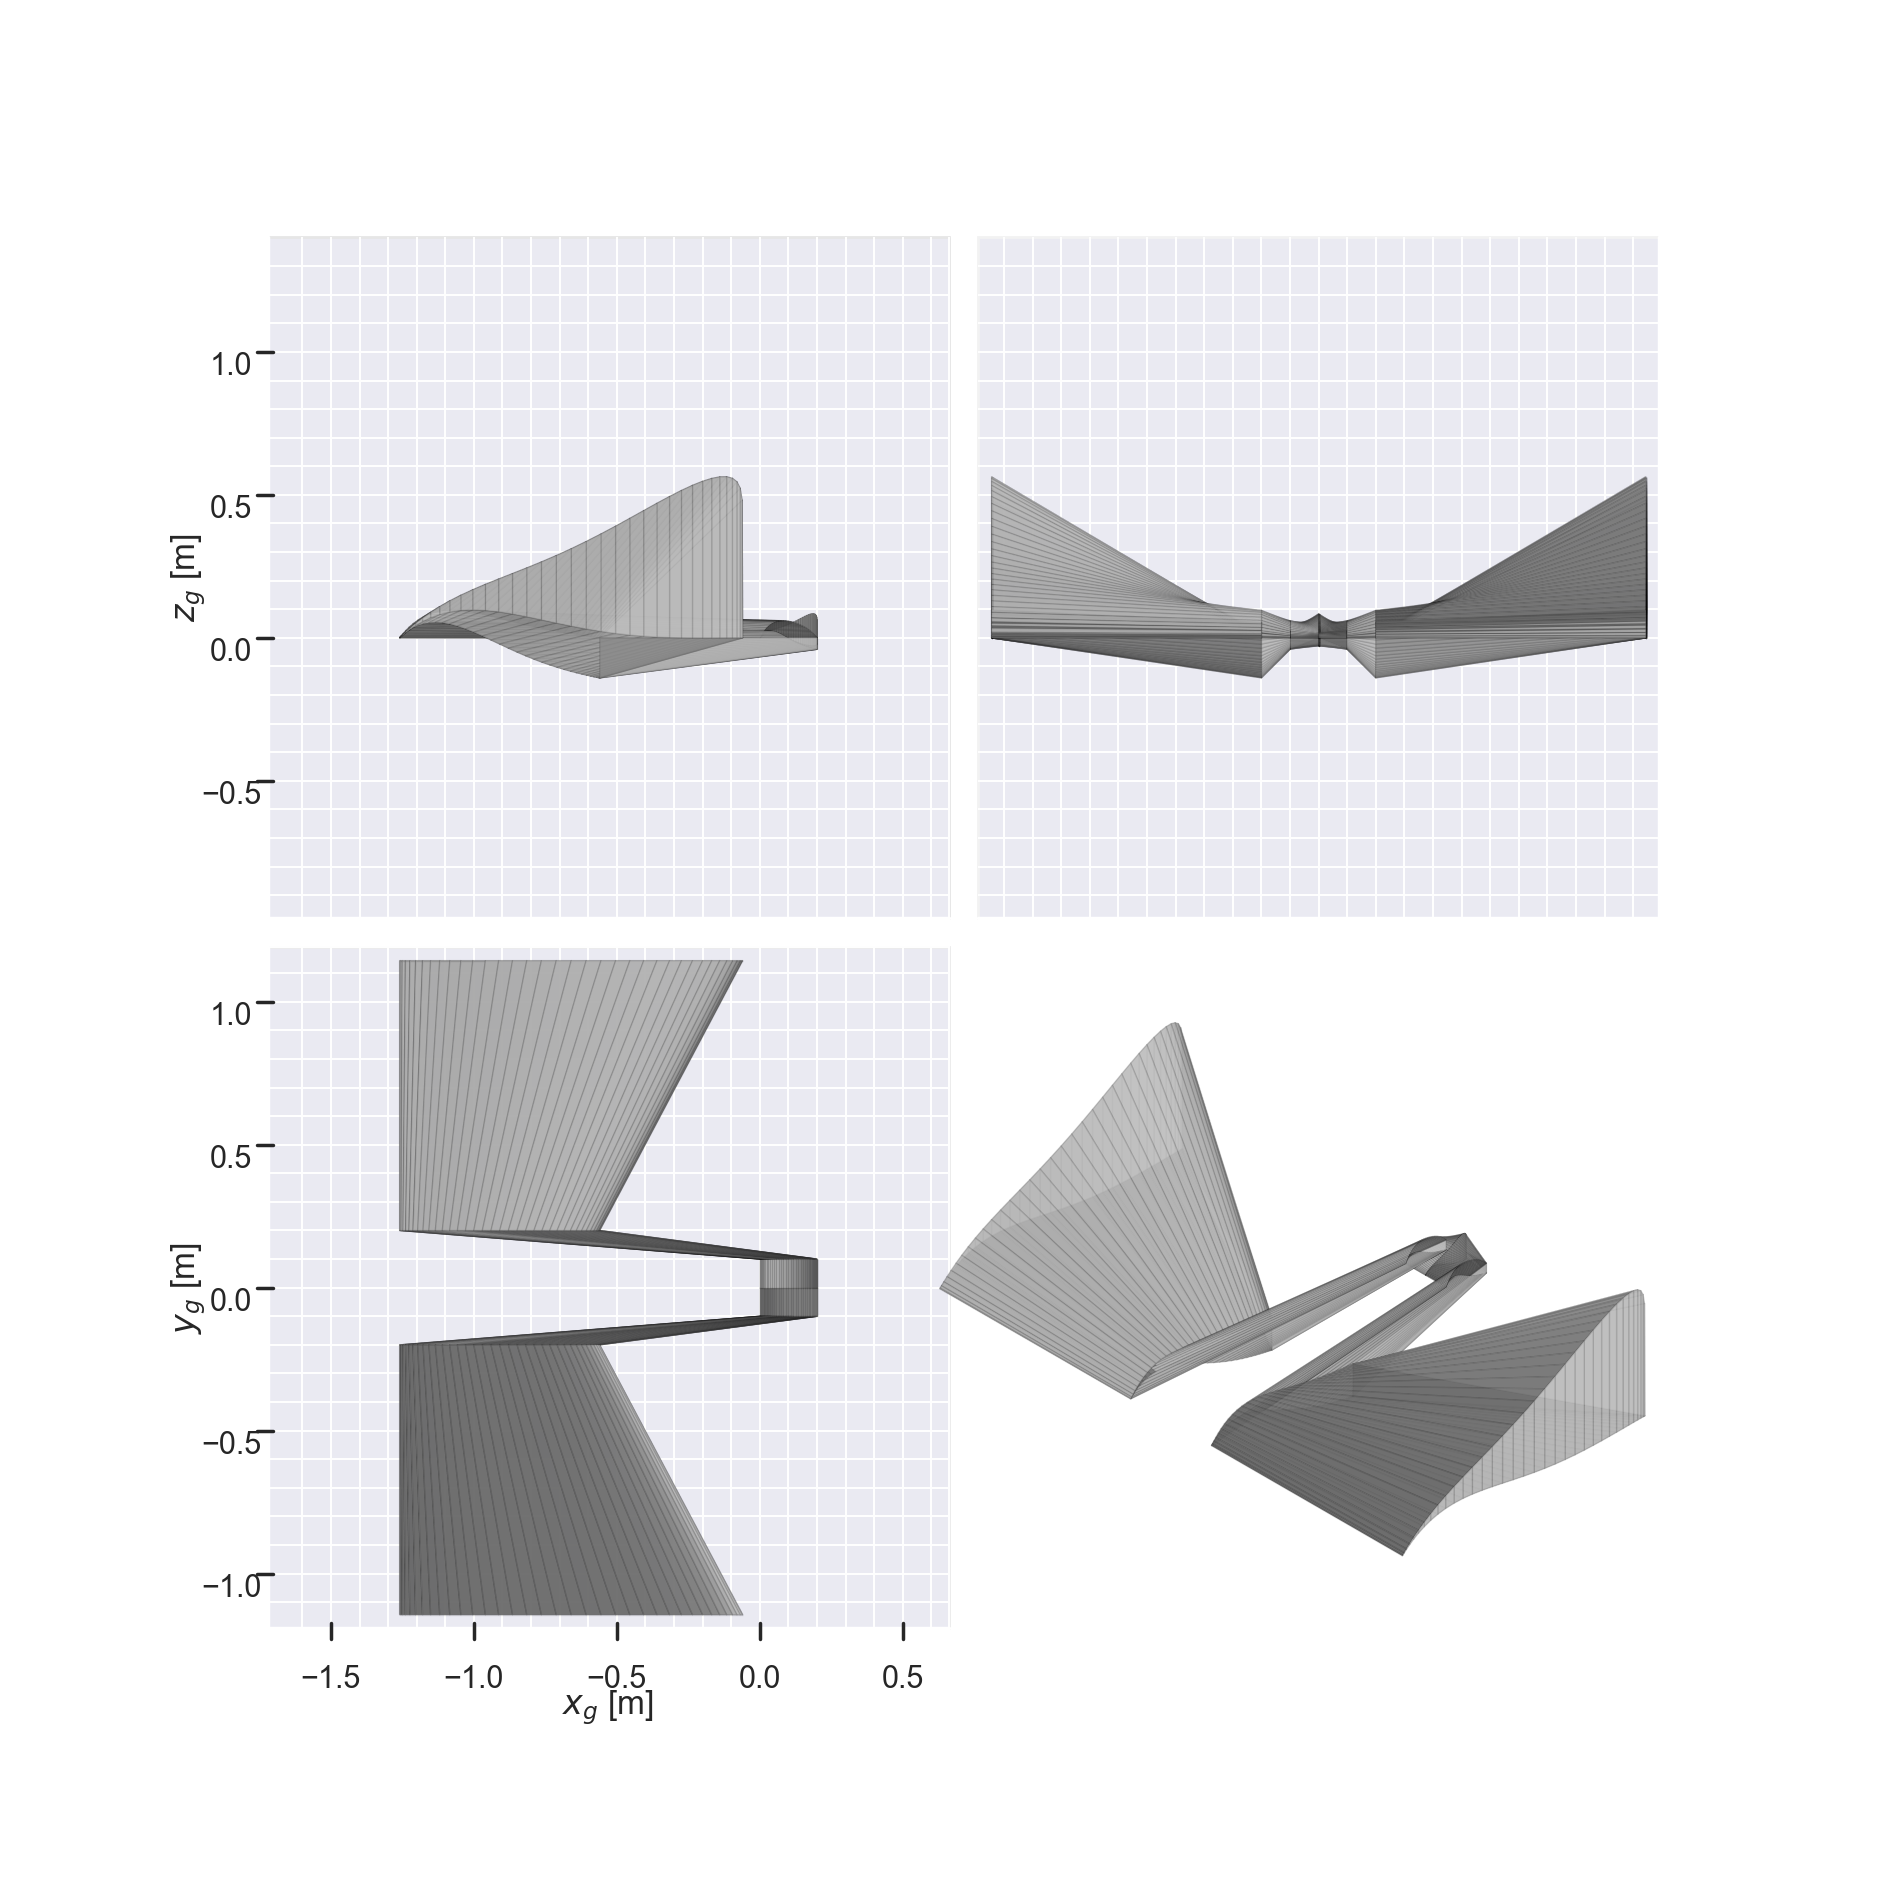

0

1

2

3

4

===

{'F_g': array([ 1.48581637e+09, -3.36383656e-02,  6.95849760e+09]), 'F_b': (-1485816366.4802778, 
-0.0336383655667305, -6958497603.904478), 'F_w': (-1485816366.4802778, -0.0336383655667305, -6958497603.904478), 
'M_g': array([-4.47582211e-02,  6.80015121e+09,  4.48959991e-02]), 'M_b': (0.04475822113454342, 6800151208.932818, 
-0.044895999133586884), 'M_w': (0.04475822113454342, 6800151208.932818, -0.044895999133586884), 'L': 
6958497603.904478, 'D': 1485816366.4802778, 'Y': -0.0336383655667305, 'l_b': 0.04475822113454342, 'm_b': 
6800151208.932818, 'n_b': -0.044895999133586884, 'CL': 4205341.992348089, 'CD': 897947.5620386149, 'CY': 
-2.032922037543748e-05, 'Cl': 6.701603764789071e-06, 'Cm': 2934836.394824484, 'Cn': -6.722233127031132e-06}

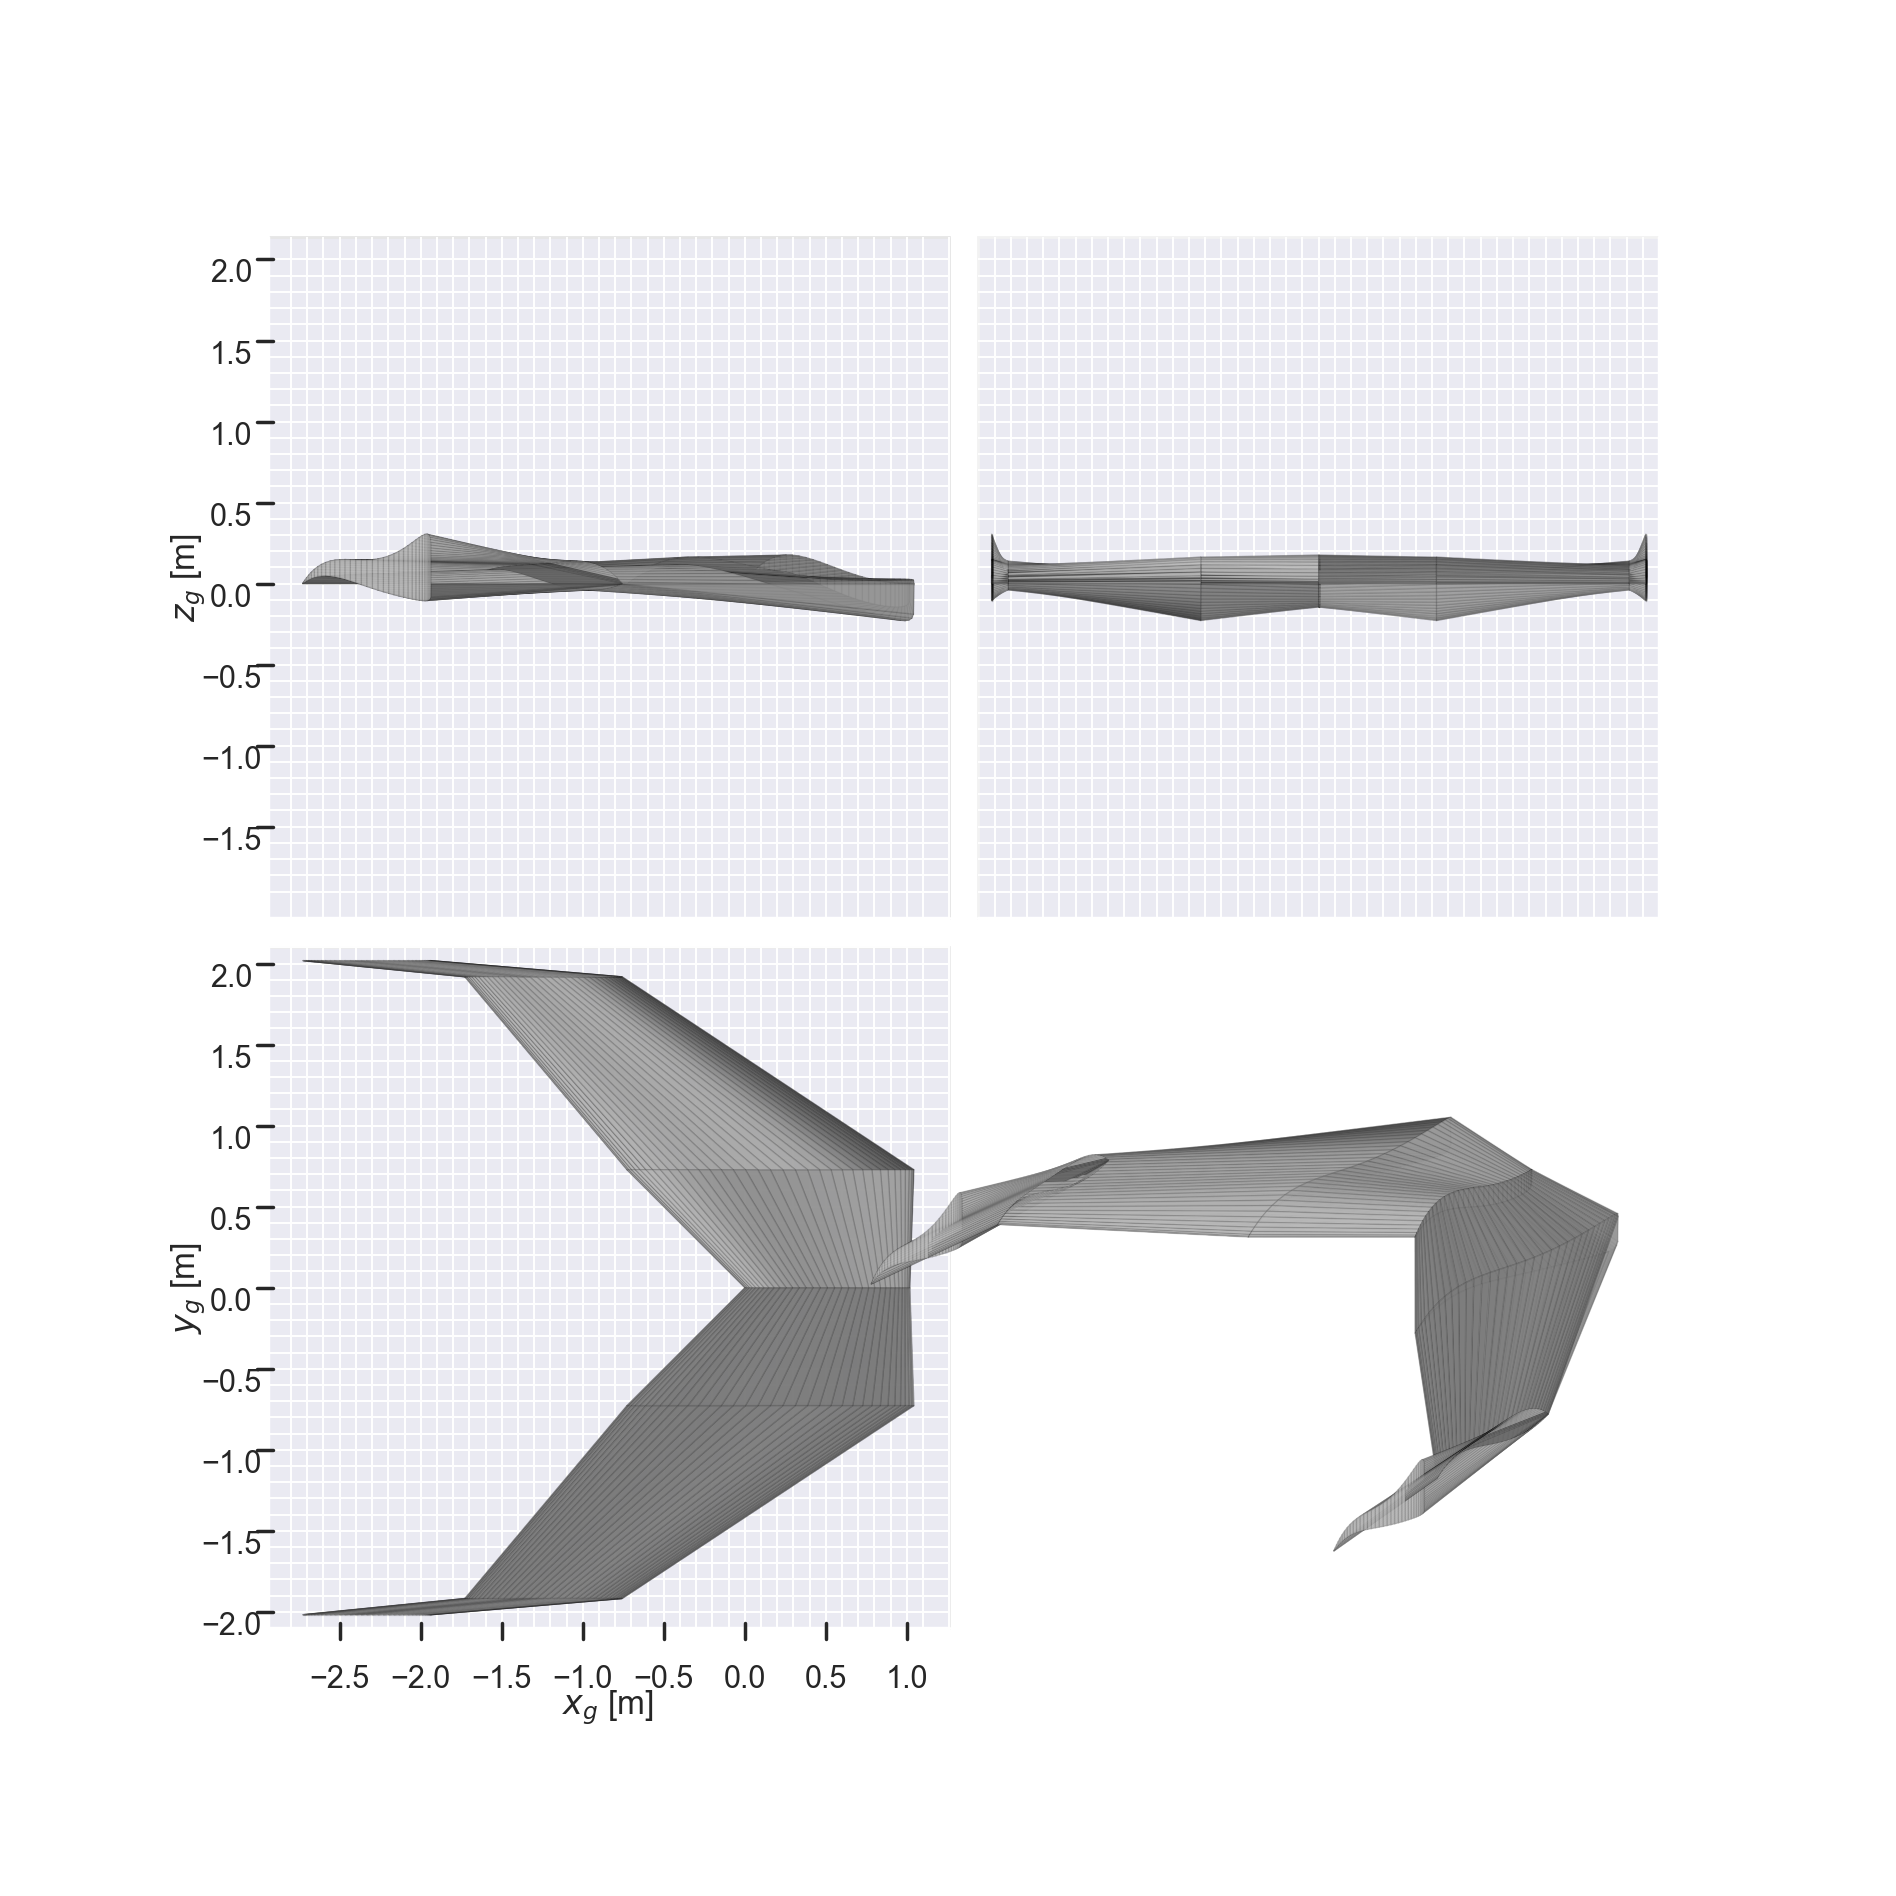

In [9]:
num_episodes = 10
for _ in range(num_episodes):
    obs, info = env.reset()
    terminated = False
    for i in range(0,steps):
        print(i)
        action, nextHiddenState = model.predict(obs)
        obs, rewards, terminated, truncated, info = env.step(action)
        # if(i%5 == 0):
        #     env.render()
    
    print("===\n\n\n\n")
    env.render()
    env.reset()
env.close()